# Pawpularity Contest Final Project

## Group 2: Austin Jin, Matt Lyons, Chandni Shah
## W207 Final Project Submission, Fall 2021

### Contents of Notebook:
- Part I: Project Description
- Part II: Tabular Metadata EDA
- Part III: Pixel Data EDA
- Part IV: Tabular Data Models
- Part V: Pixel Data Models
- Part VI: Combined Data Models
- Part VII: CNN Model with PCA
- Part VII: Conclusion
- Appendix 1: CNN Model without PCA
- Appendix 2: EfficientNet b3 CNN + Light GBM

### Part I: Project Description

<b> Project Link:</b> https://www.kaggle.com/c/petfinder-pawpularity-score

<b> Project Description:</b><br>
"In this competition, you’ll analyze raw images and metadata to predict the “Pawpularity” of pet photos. Your task is to predict engagement with a pet's profile based on the photograph for that profile. You are also provided with hand-labelled metadata for each photo. The dataset for this competition therefore comprises both images and tabular data." <br><br>

"Tabular Metadata: Each pet photo is labeled with the value of 1 (Yes) or 0 (No) for each of the following features. These labels are not used for deriving the Pawpularity score.

- Focus - Pet stands out against uncluttered background, not too close / far.
- Eyes - Both eyes are facing front or near-front, with at least 1 eye / pupil decently clear.
- Face - Decently clear face, facing front or near-front.
- Near - Single pet taking up significant portion of photo (roughly over 50% of photo width or height).
- Action - Pet in the middle of an action (e.g., jumping).
- Accessory - Accompanying physical or digital accessory / prop (i.e. toy, digital sticker), excluding collar and leash.
- Group - More than 1 pet in the photo.
- Collage - Digitally-retouched photo (i.e. with digital photo frame, combination of multiple photos).
- Human - Human in the photo.
- Occlusion - Specific undesirable objects blocking part of the pet (i.e. human, cage or fence). Note that not all blocking objects are considered occlusion.
- Info - Custom-added text or labels (i.e. pet name, description).
- Blur - Noticeably out of focus or noisy, especially for the pet’s eyes and face. For Blur entries, “Eyes” column is always set to 0."

## Part II - Tabular Metadata EDA

In order to better understand the 'petfinder-pawpularity-score' dataset, we have performed some early EDA by performing the following pre-requisites:

1. Load in the packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
from matplotlib import image
from glob import glob
import cv2

%matplotlib inline

import time
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from math import sqrt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.keras import datasets, layers, models
from tqdm.auto import tqdm
from tensorflow.keras.applications import EfficientNetB0

import lightgbm as lgb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

In [2]:
#source path (where the Pawpularity contest data resides)
path = './'

#Get the metadata (the .csv data) and put it into DataFrames
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

#Get the image data (the .jpg data) and put it into lists of filenames
train_jpg = glob(path + "train/*.jpg")
test_jpg = glob(path + "test/*.jpg")

In [3]:
# Printing the dimensions for the train metadata.
print('train_df dimensions: ', train_df.shape)
print('train_df column names: ', train_df.columns.values.tolist())

# Adding a space in between the dimensions for the train and test metadata
print('')

# Printing the dimensions for the test metadata
print('test_df dimensions: ',test_df.shape)
print('test_df column names: ', test_df.columns.values.tolist())

# After printing the shape of the train_df and test_df DataFrames, we have noticed that the train_df has 9912 rows and 14 columns whereas the test_df only has 8 rows and 13 columns. It is also worth mentioning that the test_df dataframe doesn't contain the pawpularity score.

train_df dimensions:  (9912, 14)
train_df column names:  ['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur', 'Pawpularity']

test_df dimensions:  (8, 13)
test_df column names:  ['Id', 'Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']


After printing the shape of the train_df and test_df dataframes, we can see that the train_df has 14 columns and 9912 rows, while the test_df only has 13 columns and 8 rows. It is also worth noting that the test_df particulary hasn't have pawpularity score data attached to it. We have further explored the metadata in the train dataframe since it would be the dataset for building out our models and have decided to utilize the test dataframe for practicing some predictions since it didn't contain a column for pawpularity score:

In [4]:
# Display the first 10 rows of the train_df dataframe
train_df.head(10)

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
5,001dd4f6fafb890610b1635f967ea081,0,0,1,0,0,0,0,0,0,0,0,1,74
6,0023b8a3abc93c712edd6120867deb53,0,1,1,1,0,0,0,0,1,1,0,0,22
7,0031d6a9ef7340f898c3e05f92c7bb04,0,1,1,0,0,0,1,1,0,0,1,0,35
8,0042bc5bada6d1cf8951f8f9f0d399fa,0,1,1,1,0,0,0,0,0,0,0,0,53
9,0049cb81313c94fa007286e9039af910,0,1,1,1,0,0,0,0,0,0,0,0,21


It was noticed that train_df still contains ID's of the photos which means that we won't be necessarily using this metadata when building out the models. Since we figured that it would be useful to also take a look athe distribution of the target variable, which would be the Pawpularity Score in the ranges from 1-100, a simple histogram has been plotted out to view the distribution:

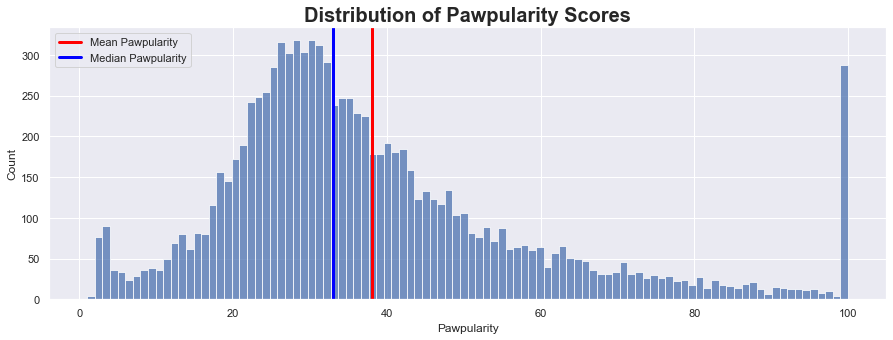

In [5]:
# Distribution for Pawpularity Scores

sns.set(rc={'figure.figsize':(15,5)})
fig = plt.figure()
sns.histplot(data=train_df, x='Pawpularity', bins=100)
plt.axvline(train_df['Pawpularity'].mean(), c='red', ls='-', lw=3, label='Mean Pawpularity')
plt.axvline(train_df['Pawpularity'].median(),c='blue',ls='-',lw=3, label='Median Pawpularity')
plt.title('Distribution of Pawpularity Scores', fontsize=20, fontweight='bold')
plt.legend()
plt.show()

After taking a look at the histogram, we see that there is a skew in the distribution of the pawpularity scores. It was interesting to see that there is a small curve close to zero Pawpularity along with another curve at the 100 Pawpularity Score with a count of close to 300. Since the EDA alone doesn't allow us to truly know the reason as to why there were many scores at 100, we have decided to keep the following theories in mind:

- Was there something unique about the animals such as their age, color, or breed that was most desirable by the people visiting the site?
- Did it have to do with the way in which photos were taken that were leading to more clicks and thus a higher Pawpularity score?
- Did it have to do with the Pawpularity score itself?
- Were there any outliers that need to be removed from the training data to improve the models that were built?
- Was there perhaps any noise in the dataset that caused the huge increase in pawpularity scores of 100?

Since we are unable to find the actual answer through EDA alone, we plan on looking to develop concrete ML models that will allow us to see which features make more impact on the high pawpularity score in order to further explain the curves.

In [6]:
# Describe the distribution of the train dataframe in a numerical way

train_df[['Pawpularity']].describe()

,Pawpularity
count,9912.000000
mean,38.039044
std,20.591990
min,1.000000
25%,25.000000
50%,33.000000
75%,46.000000
max,100.000000


<ipython-input-7-411b75508020>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-7-411b75508020>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-7-411b75508020>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-7-411b75508020>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-7-411b75508020>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
<ipython-input-7-411b75508020>:11: UserWarning: Matplotlib is cur

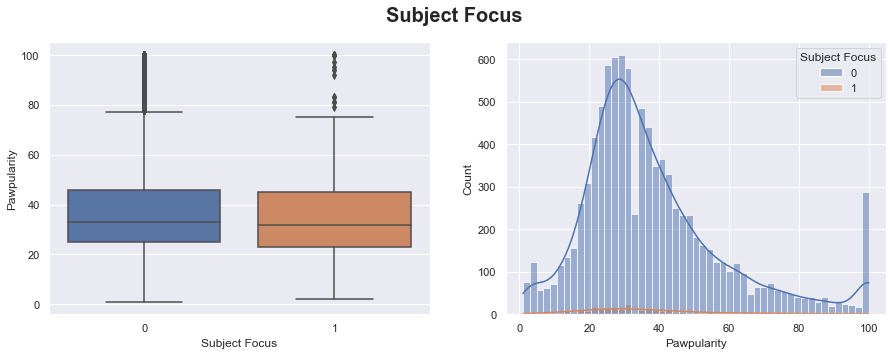

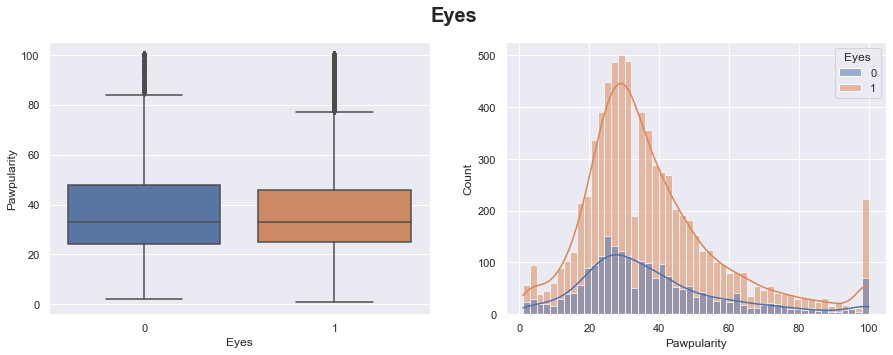

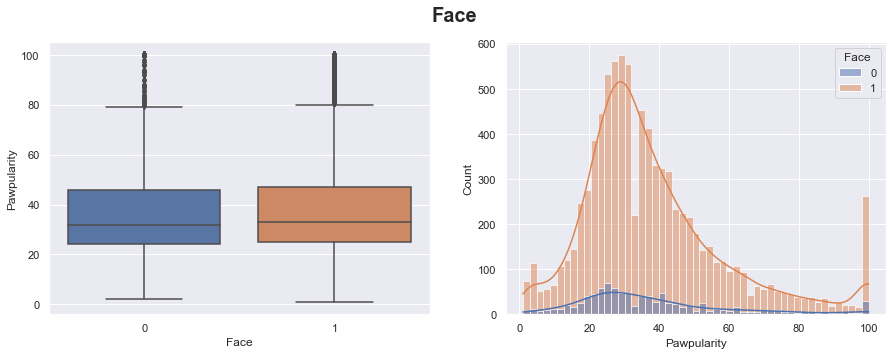

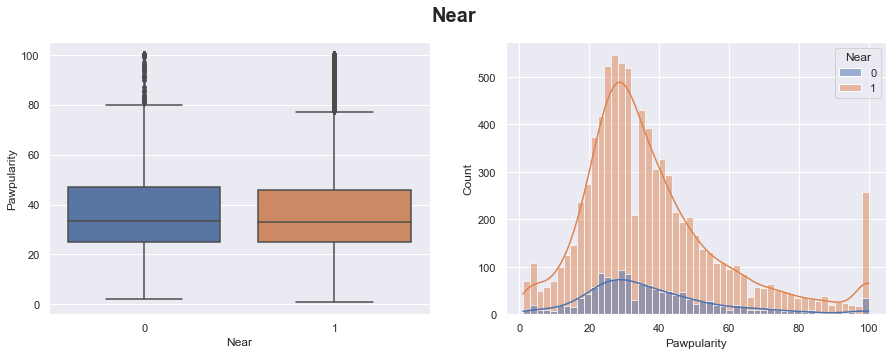

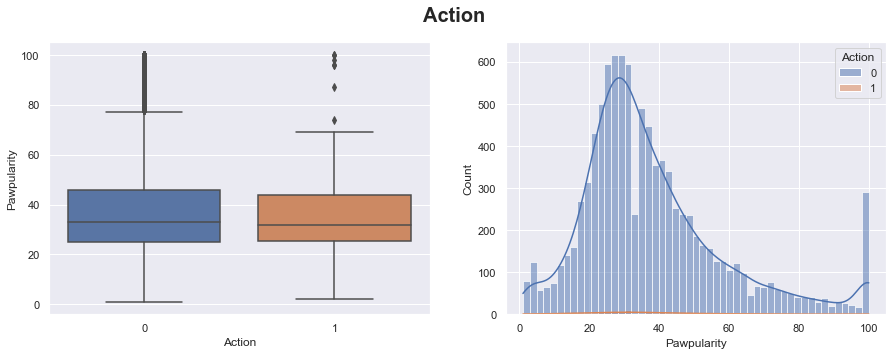

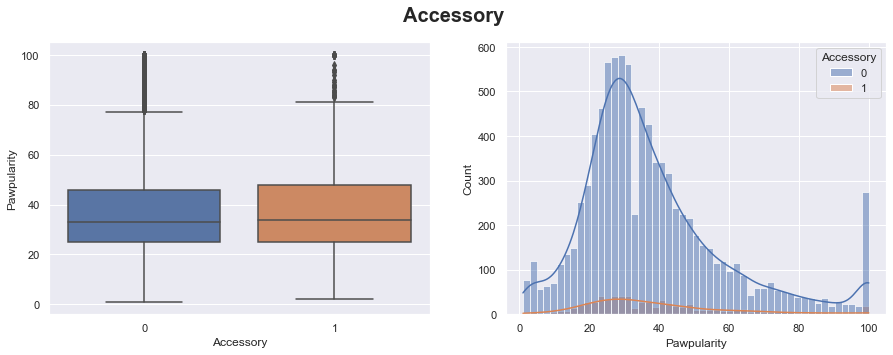

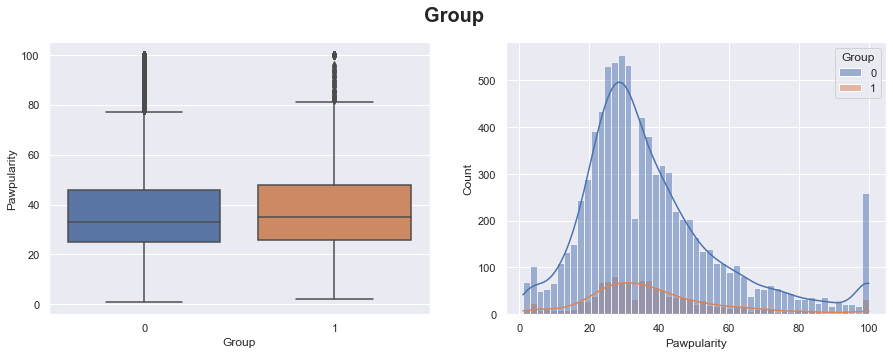

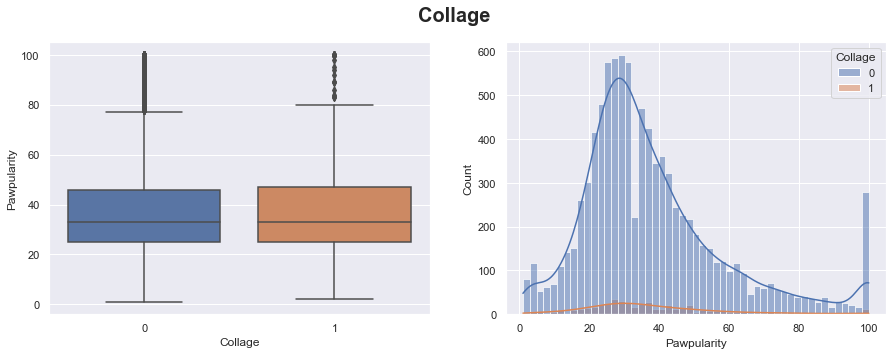

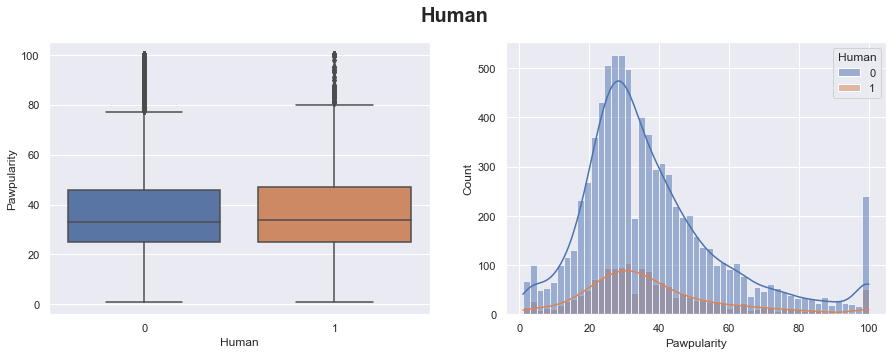

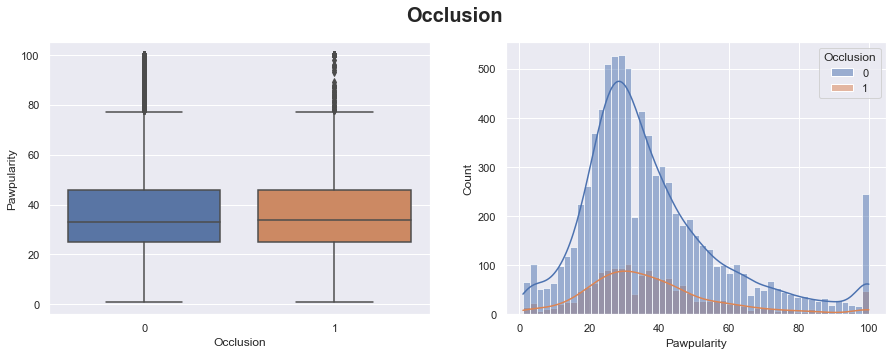

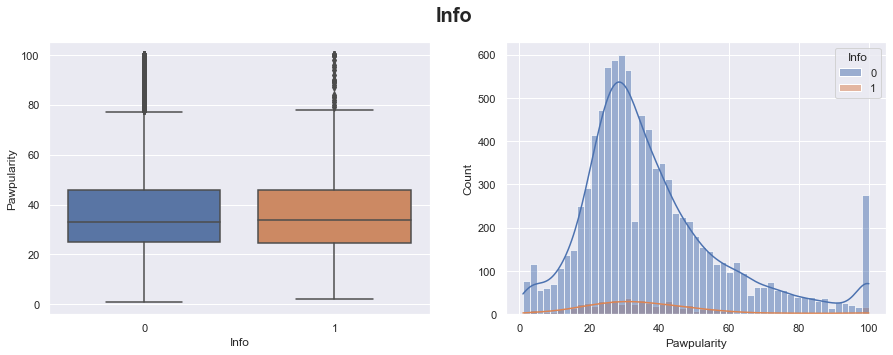

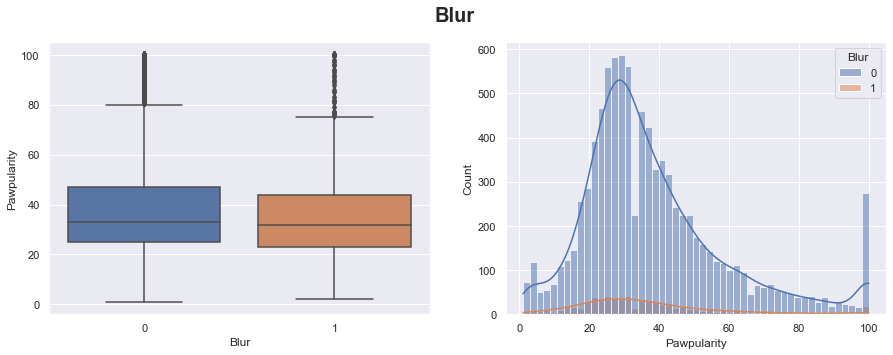

In [7]:
# Put column names into a list
feature_variables = train_df.columns.values.tolist()

# For each feature variable, doesn't include Id and Pawpularity by using [1:-1]
# Display a boxplot and distribution plot against pawpularity
for variable in feature_variables[1:-1]:
    fig, ax = plt.subplots(1,2)
    sns.boxplot(data=train_df, x=variable, y='Pawpularity', ax=ax[0])
    sns.histplot(train_df, x="Pawpularity", hue=variable, kde=True, ax=ax[1])
    plt.suptitle(variable, fontsize=20, fontweight='bold')
    fig.show()

As you can see from the charts, the distribution of pawpularity scores is very similar for each feature variable which means that changing the features doesn't end up influencing the pawpularity scores as much. This would mean that we would need to use the images and not the .csv metadata. This would've not been realized if it hadn't been for the EDA that was performed. We will focus on analyzing the pixels for the remainder of the baseline.

## Part III - Pixel EDA

Before resizing the images to a uniform size, we have decided to explore the image data by taking a look at the first image in the train_jpg dataset and plotting that initial image:

In [8]:
print(train_jpg[0])

./train\0007de18844b0dbbb5e1f607da0606e0.jpg


(720, 405, 3)


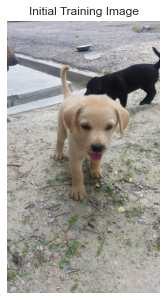

In [9]:
path_image = train_jpg[0]
array_image = plt.imread(path_image) 
print(array_image.shape)

plt.imshow(array_image)
plt.title('Initial Training Image') 
plt.axis('off')
plt.show()

Next, we have attached a Pawpularity score as the title next to each image:

The image 0's dimensions are: (720, 405, 3)


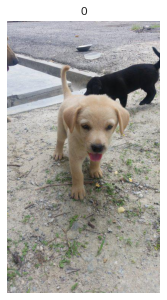

The image 1's dimensions are: (774, 1032, 3)


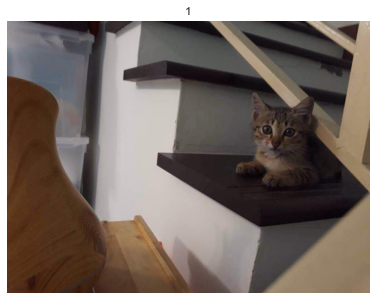

The image 2's dimensions are: (960, 720, 3)


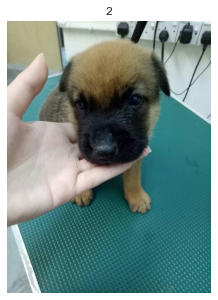

In [10]:
for x in range(3):
    path_image = train_jpg[x]
    array_image = plt.imread(path_image) 
    print("The image {}'s dimensions are: {}".format(x,array_image.shape))
    plt.imshow(array_image)
    plt.title(x) 
    plt.axis('off')
    plt.show()

After gaining an initial sense of images looked, we have decided to start resizing the images to a uniform size. In this transformation, we also add white padding to images to help preserve image quality during the resizing.

In [11]:
## Process in the training and test data, including the bw 1-d train data for baseline

train_path = './train_resized'
train_bw_path = './train_resized_bw'
test_path = './test'

train_jpg = glob(train_path + "/*.jpg")
train_bw_jpg = glob(train_bw_path + "/*.jpg")
test_jpg = glob(test_path + "/*.jpg")


train_images = [cv2.imread(file) for file in train_jpg]
train_bw_images_1d = [cv2.imread(file, 0).flatten(order = 'C') for file in train_bw_jpg] # 0 for grayscale, C for row-style flattening
test_images = [cv2.imread(file) for file in test_jpg]

In [12]:
# normalize pixel values from 0 to 1 instead of from 0 to 255.
X = np.array(train_bw_images_1d)
X = X / 255
Y = np.array(train_df['Pawpularity'])

In [13]:
X.shape

(9912, 90000)

### Examples of Transformed Images, Top Scoring Images, and Bottom Scoring Images:

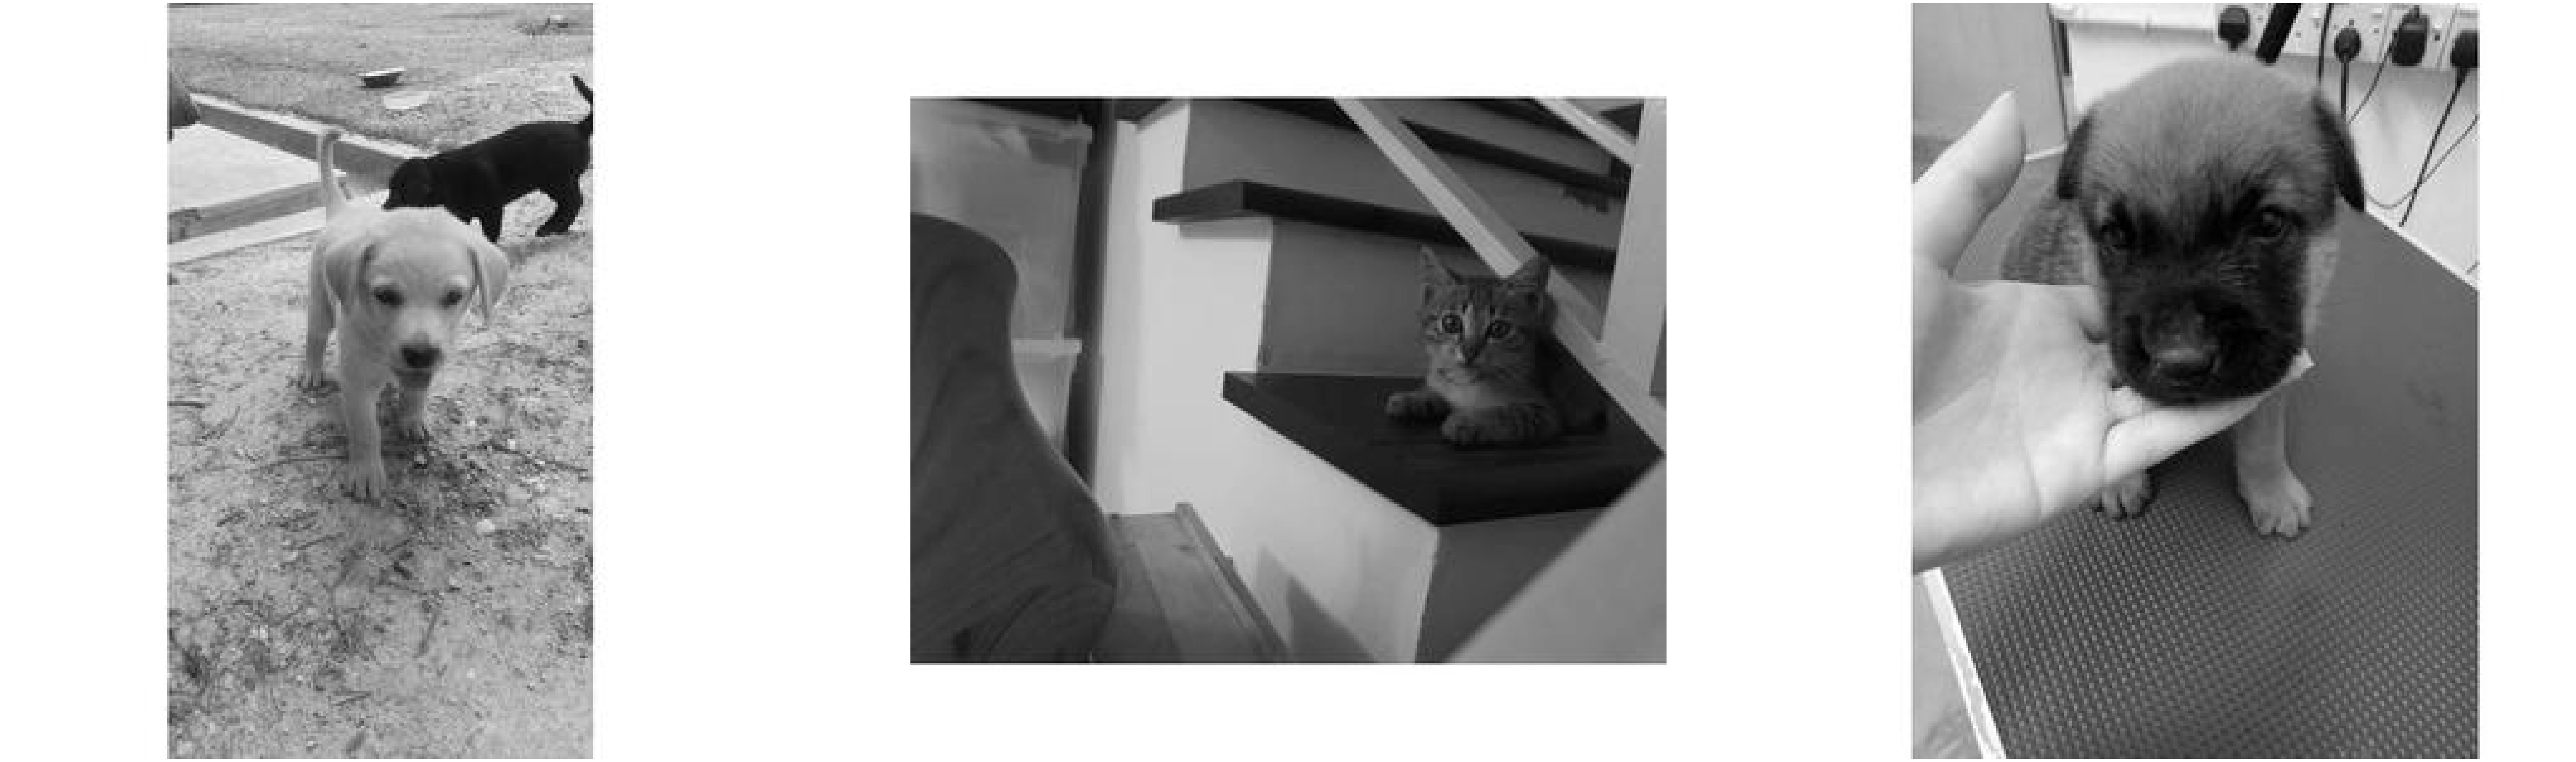

In [14]:
#examples of transformed images
pltnum = 0
plt.figure(figsize=(100,100))

for i in range(3):
    pltnum += 1
    plt.subplot(1, 3, pltnum)
    plt.imshow(X[i].reshape(300,300), cmap='gray')
    plt.axis('off')

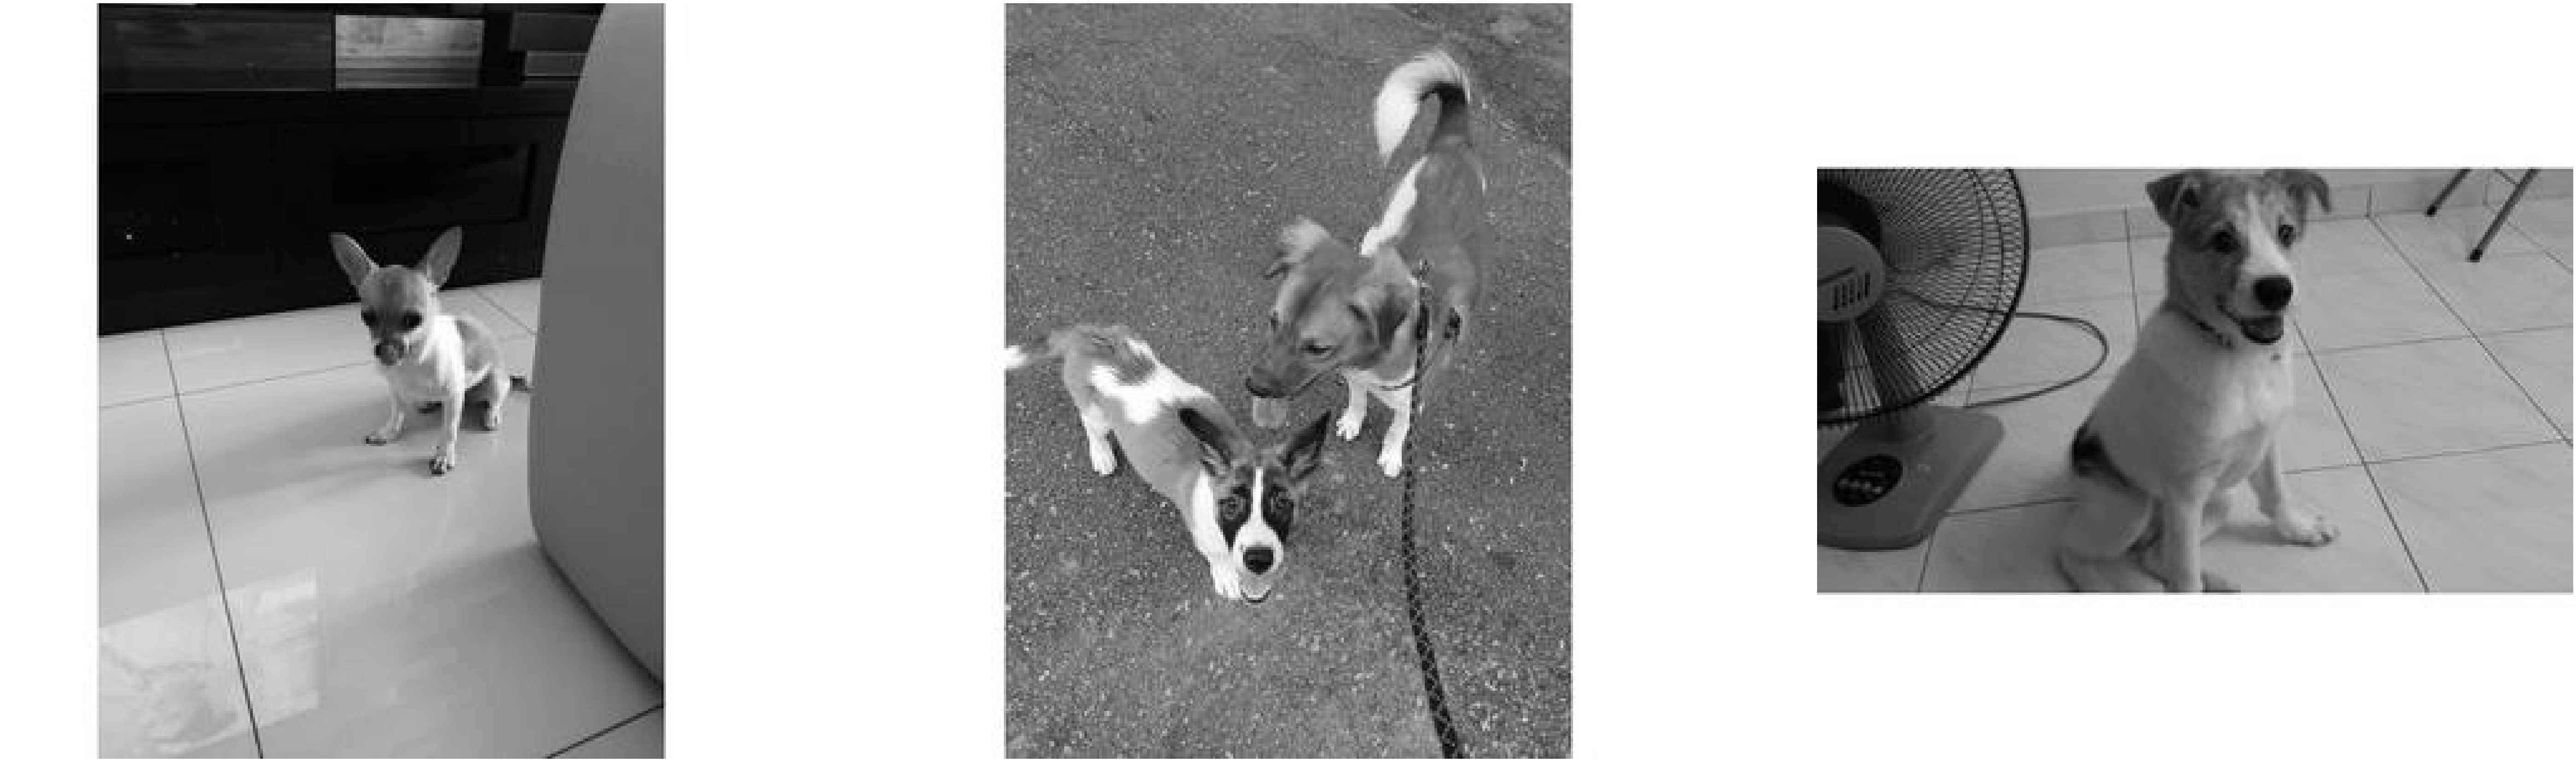

In [15]:
#examples of score = 100

y_100 = np.where(Y == 100)


pltnum = 0
plt.figure(figsize=(100,100))

for i in y_100[0][:3]:
    pltnum += 1
    plt.subplot(1, 3, pltnum)
    plt.imshow(X[i].reshape(300,300), cmap='gray')
    plt.axis('off')

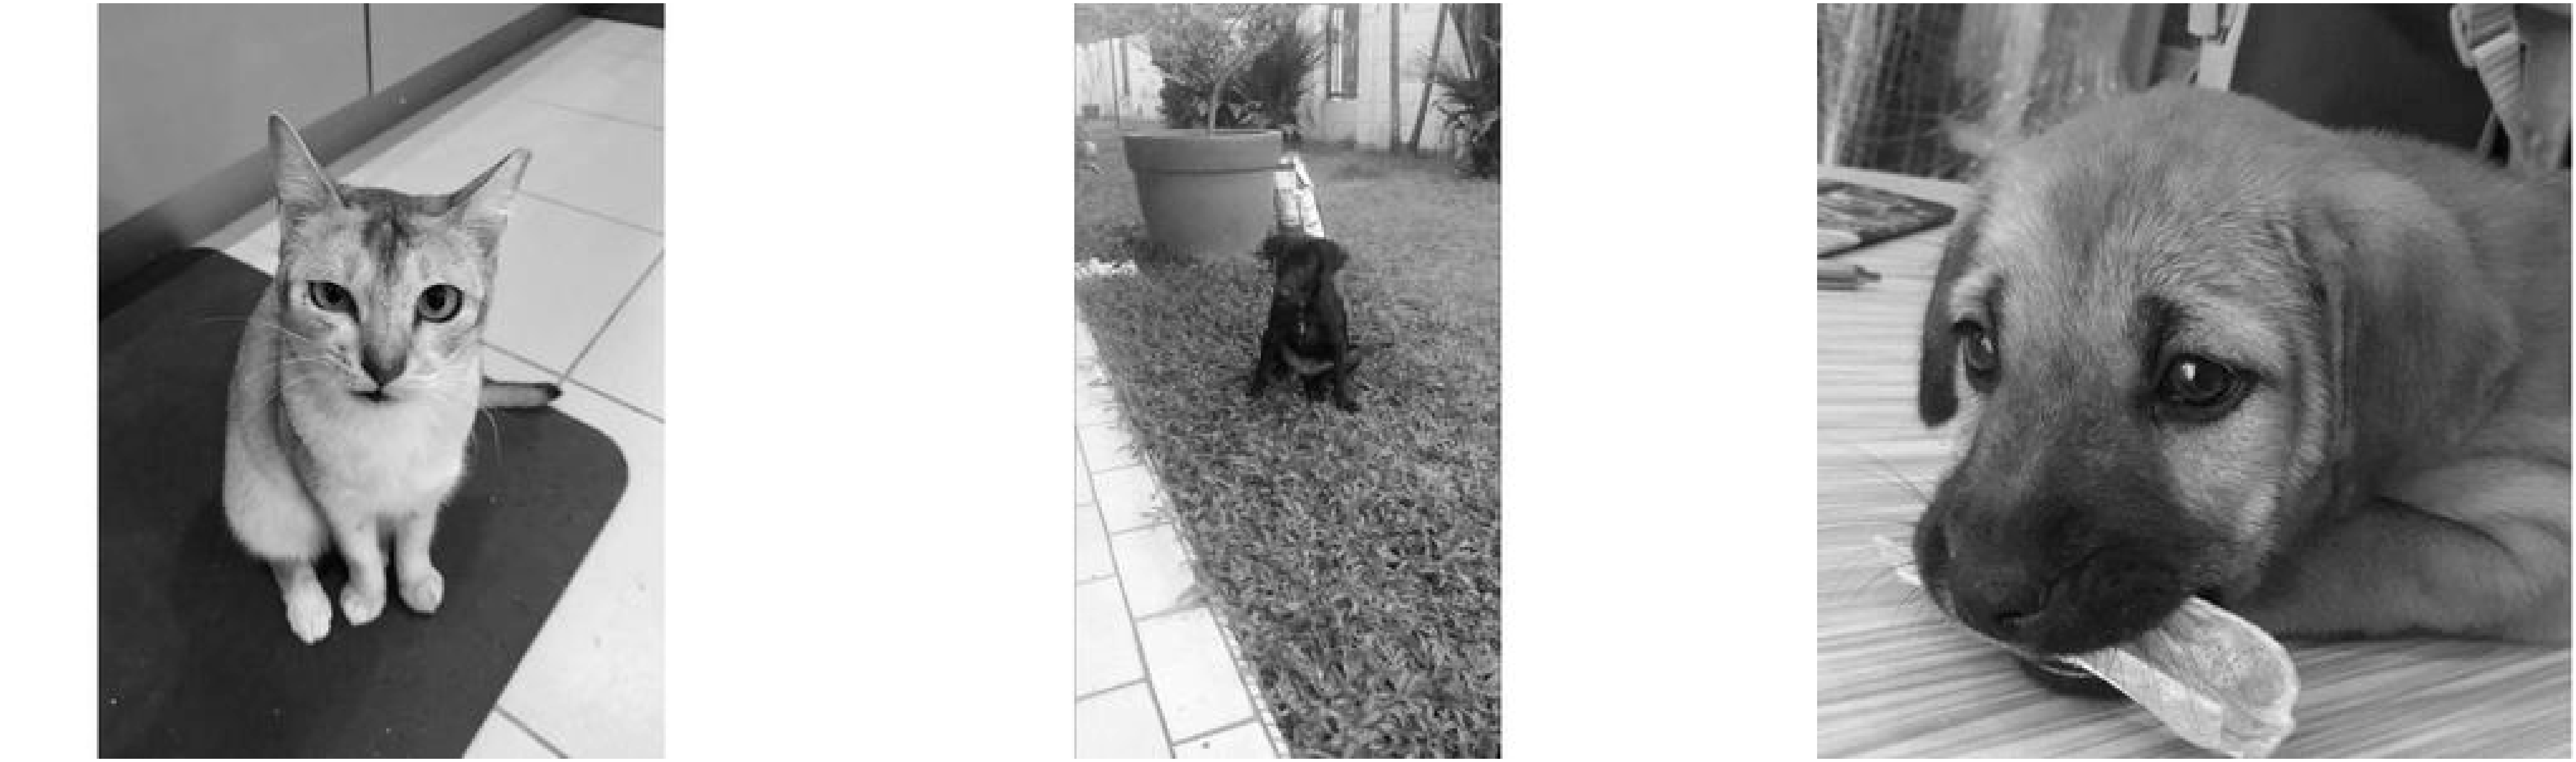

In [16]:
#example of scores in 75th percentile
y_75quant = np.where(Y == np.percentile(Y, 75))

pltnum = 0
plt.figure(figsize=(100,100))

for i in y_75quant[0][:3]:
    pltnum += 1
    plt.subplot(1, 3, pltnum)
    plt.imshow(X[i].reshape(300,300), cmap='gray')
    plt.axis('off')

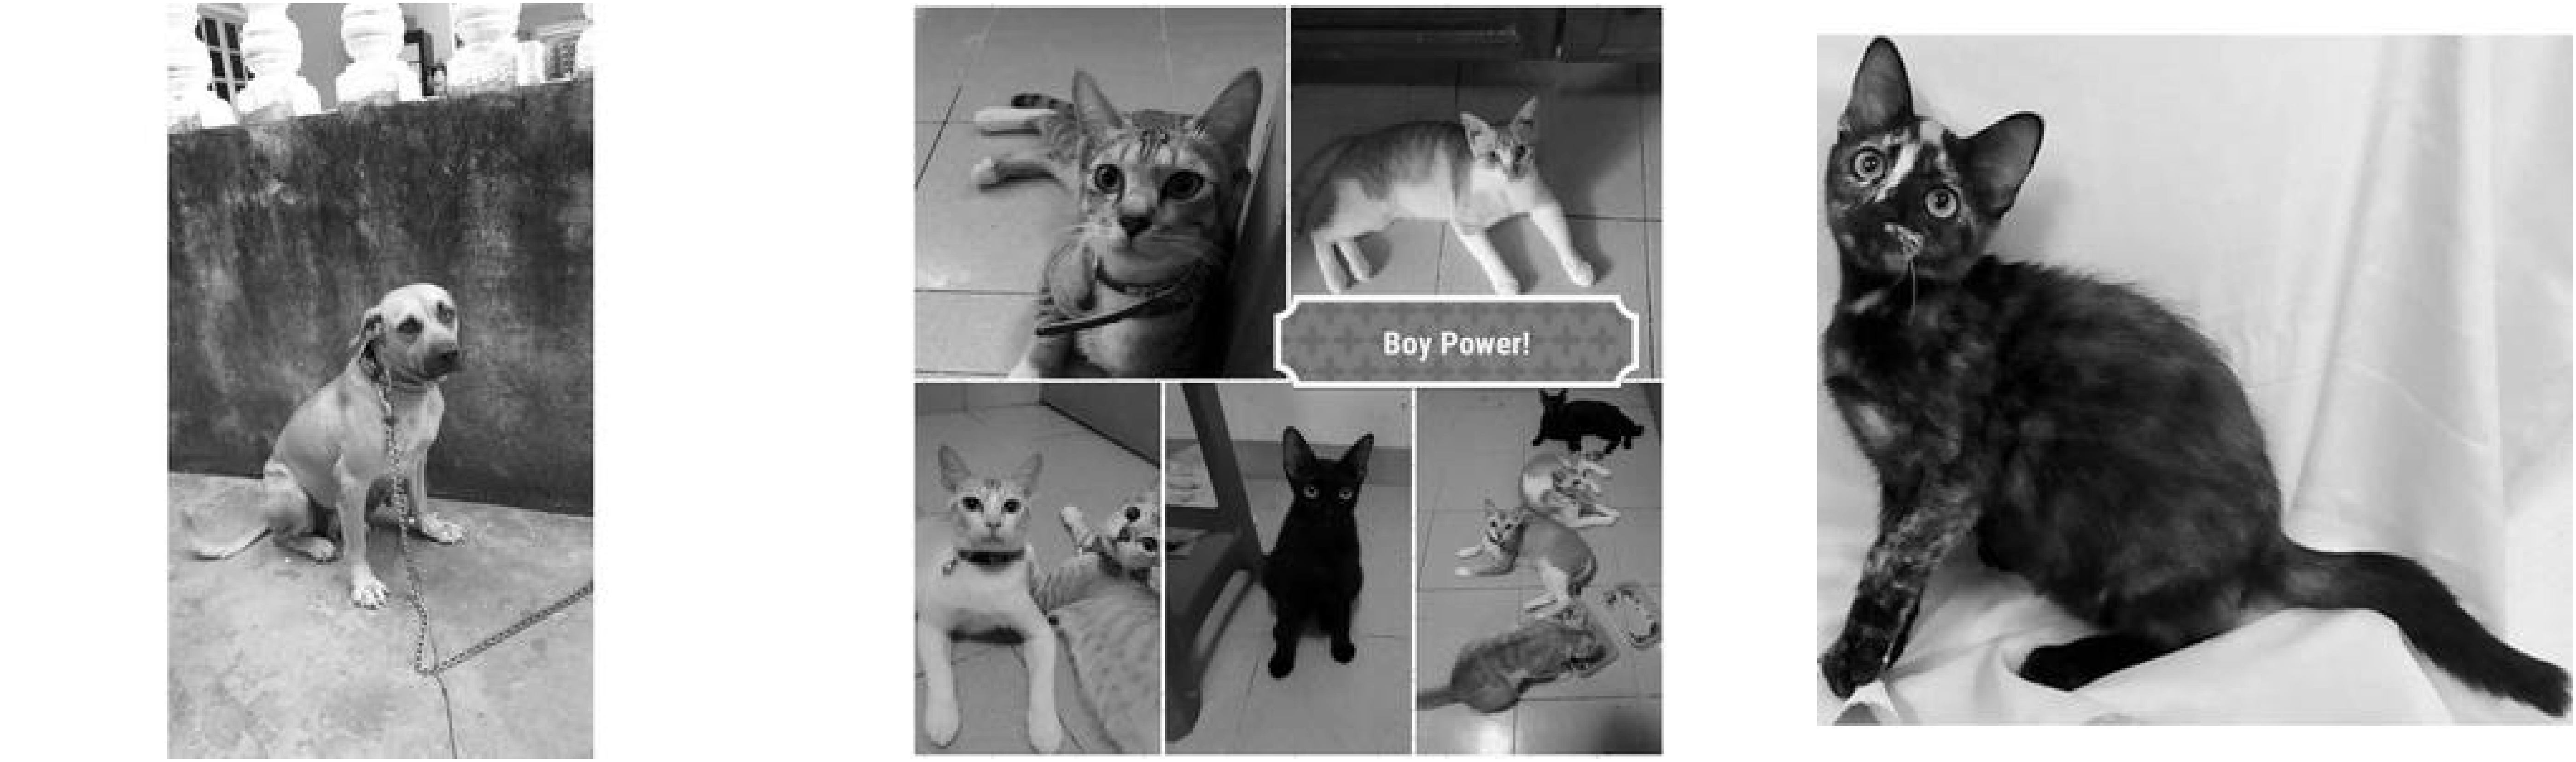

In [17]:
#example of scores in 25th percentile
y_25quant = np.where(Y == np.percentile(Y, 25))

pltnum = 0
plt.figure(figsize=(100,100))

for i in y_25quant[0][:3]:
    pltnum += 1
    plt.subplot(1, 3, pltnum)
    plt.imshow(X[i].reshape(300,300), cmap='gray')
    plt.axis('off')

## Part IV - Tabular Data Models

While we will be scoring on RMSE, we also created a custom scoring function to determine if the pawpularity predicted scores are within a specific point-range of the actual scores.

In [18]:
def proximity_score(predicted, actual, tol=5):
    size = 1
    for dim in np.shape(actual): size *= dim
    return np.count_nonzero(np.absolute(np.subtract(predicted, actual)) <= tol) / size

### KNN Regression Model (tabular data):

In [19]:
X2 = np.array(train_df)[:,1:13]

train_array, rem_array, train_labels, rem_labels = train_test_split(X2, Y, train_size = .8, random_state = 7)
dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)

print("Training shape:", (train_array.shape), (train_labels.shape))
print("Dev shape:", (dev_array.shape), (dev_labels.shape))
print("Test shape:", (test_array.shape), (test_labels.shape))

Training shape: (7929, 12) (7929,)
Dev shape: (991, 12) (991,)
Test shape: (992, 12) (992,)


In [20]:
tol = 10

def KNN(k_values):
    for val in k_values:
        KNN_model = KNeighborsRegressor(n_neighbors=val)
        KNN_model.fit(train_array, train_labels)
        test_predict = KNN_model.predict(test_array)
        print("For k = ", val, ", the RMSE is: ", round(sqrt(mean_squared_error(test_labels, test_predict)),4), ".", sep="")
        print("For k = ", val, ",", " {:.2%}".format(proximity_score(test_labels, test_predict, tol)),
              " of predicted labels are within ", tol, " of the correct label.","\n", sep="")
        
k_values = [1, 5, 9, 11, 55, 175, 201, 301, 501]
KNN(k_values)

For k = 1, the RMSE is: 26.8418.
For k = 1, 43.15% of predicted labels are within 10 of the correct label.

For k = 5, the RMSE is: 23.9278.
For k = 5, 34.27% of predicted labels are within 10 of the correct label.

For k = 9, the RMSE is: 21.3939.
For k = 9, 39.92% of predicted labels are within 10 of the correct label.

For k = 11, the RMSE is: 21.2215.
For k = 11, 40.22% of predicted labels are within 10 of the correct label.

For k = 55, the RMSE is: 21.0481.
For k = 55, 38.91% of predicted labels are within 10 of the correct label.

For k = 175, the RMSE is: 20.9354.
For k = 175, 38.00% of predicted labels are within 10 of the correct label.

For k = 201, the RMSE is: 20.9349.
For k = 201, 38.31% of predicted labels are within 10 of the correct label.

For k = 301, the RMSE is: 20.8565.
For k = 301, 40.22% of predicted labels are within 10 of the correct label.

For k = 501, the RMSE is: 20.8127.
For k = 501, 41.33% of predicted labels are within 10 of the correct label.



We have thought about different ways to handle the many values at 100, but one way would be to ignore them during training. We will see whether that gives us a more accurate value here.

In [21]:
train_df_culled = train_df[train_df['Pawpularity'] != 100]
Y = np.array(train_df_culled['Pawpularity'])
X3 = np.array(train_df_culled)[:,1:13]

train_array, rem_array, train_labels, rem_labels = train_test_split(X3, Y, train_size = .8, random_state = 7)
dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)

tol = 10

def KNN(k_values):
    for val in k_values:
        KNN_model = KNeighborsRegressor(n_neighbors=val)
        KNN_model.fit(train_array, train_labels)
        test_predict = KNN_model.predict(test_array)
        print("For k = ", val, ", the RMSE is: ", round(sqrt(mean_squared_error(test_labels, test_predict)),4), ".", sep="")
        print("For k = ", val, ",", " {:.2%}".format(proximity_score(test_labels, test_predict, tol)),
              " of predicted labels are within ", tol, " of the correct label.","\n", sep="")
        
k_values = [1, 5, 9, 11, 55, 175, 201, 301, 501]
KNN(k_values)

For k = 1, the RMSE is: 26.5359.
For k = 1, 34.89% of predicted labels are within 10 of the correct label.

For k = 5, the RMSE is: 20.5871.
For k = 5, 47.46% of predicted labels are within 10 of the correct label.

For k = 9, the RMSE is: 18.8255.
For k = 9, 44.76% of predicted labels are within 10 of the correct label.

For k = 11, the RMSE is: 18.8092.
For k = 11, 44.86% of predicted labels are within 10 of the correct label.

For k = 55, the RMSE is: 18.4851.
For k = 55, 42.89% of predicted labels are within 10 of the correct label.

For k = 175, the RMSE is: 18.4635.
For k = 175, 45.79% of predicted labels are within 10 of the correct label.

For k = 201, the RMSE is: 18.4747.
For k = 201, 44.76% of predicted labels are within 10 of the correct label.

For k = 301, the RMSE is: 18.4559.
For k = 301, 44.96% of predicted labels are within 10 of the correct label.

For k = 501, the RMSE is: 18.4558.
For k = 501, 47.04% of predicted labels are within 10 of the correct label.



<b>Indeed, omitting the 100s yielded better performance, therefore we will continue to do so.

### Linear Regression Model (tabular data)

In [22]:
lr_model = LinearRegression()
lr_model.fit(train_array, train_labels)
lr_model.score(test_array, test_labels)

0.003333985037433318

In [23]:
lr_predict_tab = lr_model.predict(test_array)
print("LR RMSE is: ", round(sqrt(mean_squared_error(test_labels, lr_predict_tab)), 4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, lr_predict_tab, tol)), 
      " of the LR-predicted labels were within", tol, "of the correct label.")

LR RMSE is: 18.4451.
46.83%  of the LR-predicted labels were within 10 of the correct label.


Despite what we anticipated to be poor predictive power of the tabular data, they performed, though not amazingly well, not horribly, and in fact outperformed the pixel data using linear regression (those models will be presented in the next section).

### Decision Trees (Tabular Data)

In [24]:
#create the Regressor
tree_reg = DecisionTreeRegressor(max_depth = 3, min_samples_split = 10)

#train the model and predict labels
tree_reg.fit(train_array, train_labels)
tree_reg_pred = tree_reg.predict(test_array)

#print the RMSE and Proximity Scores
tree_reg_RMSE = sqrt(mean_squared_error(test_labels, tree_reg_pred))
print("Decision Tree RMSE is: ", round(tree_reg_RMSE,4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, tree_reg_pred, tol)),
              "of predicted labels are within", tol, "of the correct label.","\n")

Decision Tree RMSE is: 18.5166.
46.21% of predicted labels are within 10 of the correct label. 



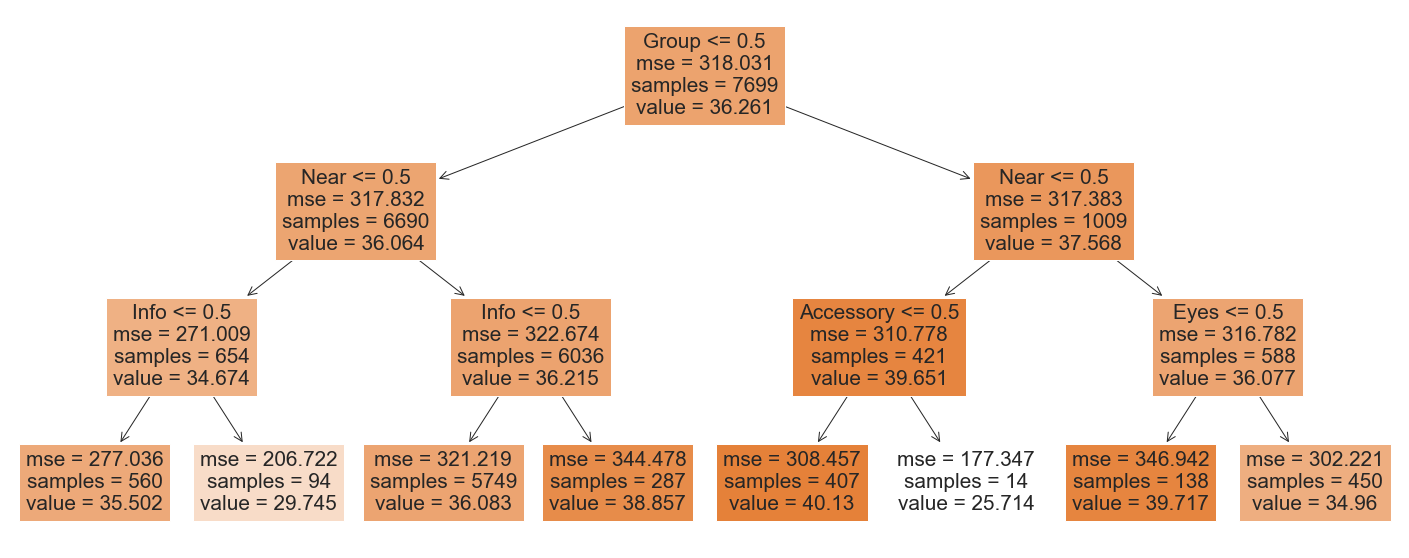

In [25]:
#visualize the decision tree
fig = plt.figure(figsize=(25,10))
plot = tree.plot_tree(tree_reg, feature_names=train_df.columns.values.tolist()[1:13], filled=True)

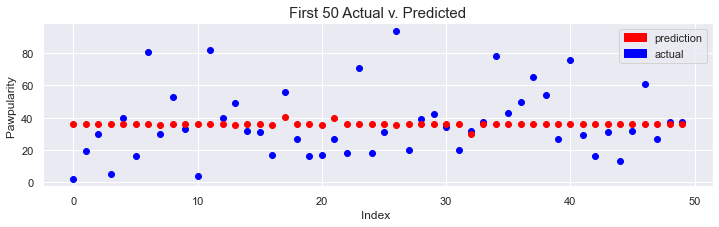

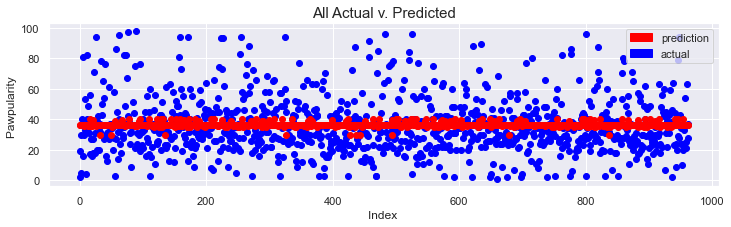

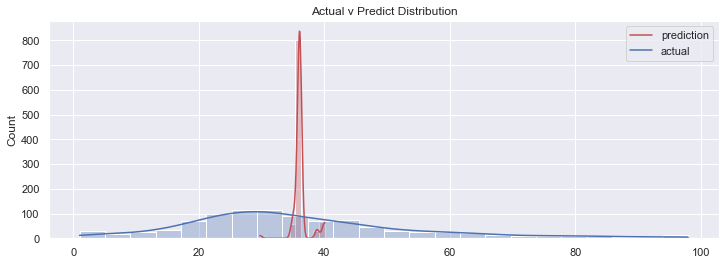

In [26]:
#let's see what our predictions look like vs the actual 
def ActualvPredictionsGraph(test_labels,y_pred,title):
    if max(test_labels) >= max(y_pred):
        my_range = int(max(test_labels))
    else:
        my_range = int(max(y_pred))
    plt.figure(figsize=(12,3))
    plt.scatter(range(len(test_labels)), test_labels, color='blue')
    plt.scatter(range(len(y_pred)), y_pred, color='red')
    plt.xlabel('Index ')
    plt.ylabel('Pawpularity ')
    plt.title(title,fontdict = {'fontsize' : 15})
    plt.legend(handles = [mpatches.Patch(color='red', label='prediction'),mpatches.Patch(color='blue', label='actual')])
    plt.show()
    return

#plot it
ActualvPredictionsGraph(test_labels[0:50], tree_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(test_labels, tree_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(tree_reg_pred,color='r',alpha=0.3,stat='count', kde=True)
sns.histplot(test_labels,color='b',alpha=0.3,stat='count', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

We observe our predictions are guessing near the mean, which doesn't align with the true shape of the scores distribution.

### Random Forest (Tabular Data)

We will explore if a random forest ensemble of 100 trees will help improve our model performance:

In [27]:
#create the Random Forest ensemble
RF_reg = RandomForestRegressor(n_estimators=100, max_depth=3)

#train the model and predict labels
RF_reg.fit(train_array, train_labels)
RF_reg_pred = RF_reg.predict(test_array)

#Print the RMSE and Proximity Scores
RF_reg_RMSE = sqrt(mean_squared_error(test_labels, RF_reg_pred))
print("Random Forest RMSE is: ", round(RF_reg_RMSE,4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, RF_reg_pred, tol)),
              "of predicted labels are within", tol, "of the correct label.","\n")

Random Forest RMSE is: 18.4481.
46.73% of predicted labels are within 10 of the correct label. 



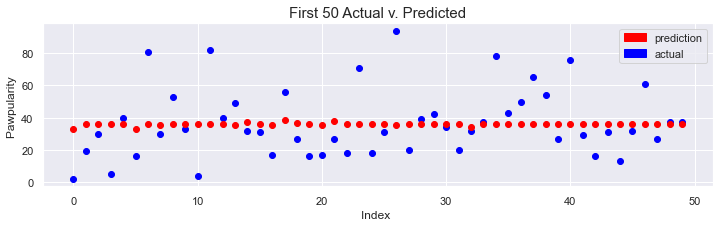

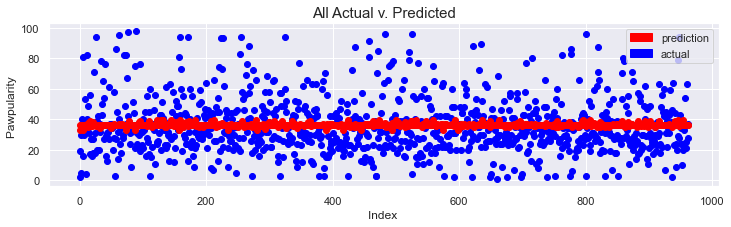

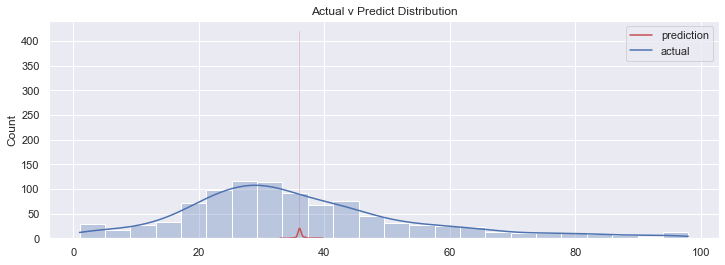

In [28]:
#plot it
ActualvPredictionsGraph(test_labels[0:50], RF_reg_pred[0:50], "First 50 Actual v. Predicted")
ActualvPredictionsGraph(test_labels, RF_reg_pred, "All Actual v. Predicted")

#plot actual v predicted in histogram form
plt.figure(figsize=(12,4))
sns.histplot(RF_reg_pred,color='r',alpha=0.3,stat='count',kde=True)
sns.histplot(test_labels,color='b',alpha=0.3,stat='count', kde=True)
plt.legend(labels=['prediction','actual'])
plt.title('Actual v Predict Distribution')
plt.show()

Using a random forest ensemble of decision trees does not largely improve our model. The model is still predicting near the mean and the distribution of scores still does not align.

We have tested KNN Regression, Linear Regression, Decision Tree Regression, and a Random Forest Ensemble on the tabular data. Of the tested models, the Linear Regression and Random Forest Ensemble has produced the lowest RMSE scores of 18.4451 and 18.4481 respectively.

We will move on to explore the image pixel data separately.

## Part V - Pixel Data Models

Earlier, we loaded in all of the images, but we need to now exclude the outliers (Pawpularity = 100) as we did above.

In [29]:
## Process in the training and test data, including the bw 1-d train data for baseline

train = pd.read_csv('./train.csv')
train = train[train['Pawpularity'] != 100]
test = pd.read_csv('./test.csv')

def get_train_file_path(image_id):
    return "./train_resized/{}.jpg".format(image_id)

def get_train_bw_file_path(image_id):
    return "./train_resized_bw/{}.jpg".format(image_id)

def get_test_file_path(image_id):
    return "./test/{}.jpg".format(image_id)

train['file_path'] = train['Id'].apply(get_train_file_path)
train['file_path_bw'] = train['Id'].apply(get_train_bw_file_path)
test['file_path'] = test['Id'].apply(get_test_file_path)

train_images = [cv2.imread(file) for file in train['file_path']]
train_bw_images_1d = [cv2.imread(file, 0).flatten(order = 'C') for file in train['file_path_bw']] # 0 for grayscale, C for row-style flattening
test_images = [cv2.imread(file) for file in test['file_path']]

In [30]:
# split our new culled image data identically as before
X4 = np.array(train_bw_images_1d)
Y = np.array(train_df_culled['Pawpularity'])

train_array, rem_array, train_labels, rem_labels = train_test_split(X4, Y, train_size = .8, random_state = 7)
dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)

print("Training shape:", (train_array.shape), (train_labels.shape))
print("Dev shape:", (dev_array.shape), (dev_labels.shape))
print("Test shape:", (test_array.shape), (test_labels.shape))

Training shape: (7699, 90000) (7699,)
Dev shape: (962, 90000) (962,)
Test shape: (963, 90000) (963,)


### KNN Regression Model (grayscale image pixel data)

In [31]:
tol = 10

def KNN(k_values):
    for val in k_values:
        KNN_model = KNeighborsRegressor(n_neighbors=val)
        KNN_model.fit(train_array, train_labels)
        test_predict = KNN_model.predict(test_array)
        print("For k = ", val, ", the RMSE is: ", round(sqrt(mean_squared_error(test_labels, test_predict)),4), ".", sep="")
        print("For k = ", val, ",", " {:.2%}".format(proximity_score(test_labels, test_predict, tol)),
              " of predicted labels are within ", tol, " of the correct label.","\n", sep="")
        
k_values = [1, 5, 9, 11, 55, 175, 201, 301, 501]
KNN(k_values)

For k = 1, the RMSE is: 25.5101.
For k = 1, 37.69% of predicted labels are within 10 of the correct label.

For k = 5, the RMSE is: 19.998.
For k = 5, 44.03% of predicted labels are within 10 of the correct label.

For k = 9, the RMSE is: 19.0185.
For k = 9, 45.79% of predicted labels are within 10 of the correct label.

For k = 11, the RMSE is: 18.8829.
For k = 11, 45.79% of predicted labels are within 10 of the correct label.

For k = 55, the RMSE is: 18.4529.
For k = 55, 46.83% of predicted labels are within 10 of the correct label.

For k = 175, the RMSE is: 18.4098.
For k = 175, 47.56% of predicted labels are within 10 of the correct label.

For k = 201, the RMSE is: 18.4192.
For k = 201, 46.94% of predicted labels are within 10 of the correct label.

For k = 301, the RMSE is: 18.4356.
For k = 301, 47.04% of predicted labels are within 10 of the correct label.

For k = 501, the RMSE is: 18.4513.
For k = 501, 47.46% of predicted labels are within 10 of the correct label.



We observe the KNN regression produces results roughly consistent with the tabular data, with best results around k=175. We will move forward with using k=175 due to these results. With k=175, we achieve an RMSE score of 18.4098.

### Linear Regression Model (grayscale image pixel data)

In [32]:
lr_model = LinearRegression()
lr_model.fit(train_array, train_labels)
lr_model.score(test_array, test_labels)

-1.3066280263333168

In [33]:
lr_predict = lr_model.predict(test_array)
print("LR RMSE is: ", round(sqrt(mean_squared_error(test_labels, lr_predict)), 4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, lr_predict, tol)), 
      " of the LR-predicted labels were within ", tol, " of the correct label.", sep="")

LR RMSE is: 28.0605.
30.63% of the LR-predicted labels were within 10 of the correct label.


We achieve a Linear Regression score of 28.0605 and a negative R squared score, suggesting poor performance using this model.


Next, we will explore if performing dimensionality reduction through PCA achieves similar scores and helps us optimize our algorithms.

### Dimensionality Reduction with PCA

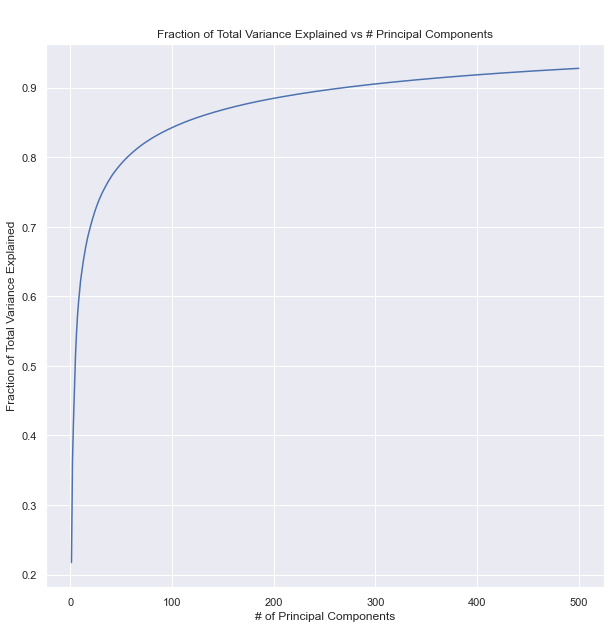

In [34]:
#should we perform PCA?
pca_mod = PCA(n_components=500)
train_pca = pca_mod.fit_transform(train_array)

explained_variance = np.cumsum(pca_mod.explained_variance_ratio_)


#print graph figure
plt.figure(figsize = (10,10))
plt.title('\n\nFraction of Total Variance Explained vs # Principal Components')
plt.plot([i for i in range(1, 501)], np.cumsum(pca_mod.explained_variance_ratio_))
plt.xlabel('# of Principal Components')
plt.ylabel('Fraction of Total Variance Explained')
plt.show()

We can see 300 components explains over 90% of variance. We will test how our models perform using PCA with at least 300 components. In order to continue using "square" "images", <b>we will be using 324 (18 * 18) PCA components.

In [35]:
pca_mod = PCA(n_components=324)
train_pca = pca_mod.fit_transform(train_array)
test_pca = pca_mod.transform(test_array)

### KNN Regression Model with PCA:

In [36]:
def KNN(k_values):
    for val in k_values:
        KNN_model = KNeighborsRegressor(n_neighbors=val)
        KNN_model.fit(train_pca, train_labels)
        test_predict = KNN_model.predict(test_pca)
        print("For k = ", val, ", the RMSE is: ", round(sqrt(mean_squared_error(test_labels, test_predict)),4), ".", sep="")
        print("For k = ", val, ",", " {:.2%}".format(proximity_score(test_labels, test_predict, tol)),
              " of predicted labels are within ", tol, " of the correct label.","\n", sep="")
        
KNN([175])

For k = 175, the RMSE is: 18.4054.
For k = 175, 47.35% of predicted labels are within 10 of the correct label.



We can see PCA helped optimize our algorithms because we achieve similar RMSE scores of ~18.4 for our KNN model while having 324 features compared to 90,000.

### Linear Regression with PCA:

In [37]:
lr_model = LinearRegression()
lr_model.fit(train_pca, train_labels)
lr_model.score(test_pca, test_labels)

-0.043509824591108526

In [38]:
lr_predict = lr_model.predict(test_pca)
print("LR RMSE is: ", round(sqrt(mean_squared_error(test_labels, lr_predict)), 4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, lr_predict, tol)), 
      " of the LR-predicted labels were within ", tol, " of the correct label.", sep="")

LR RMSE is: 18.8736.
45.07% of the LR-predicted labels were within 10 of the correct label.


For our Linear Regression model, PCA appears to have improved our scores from 28.0605 (without PCA) to 18.8736 (with PCA).

Next, we will see if we can combine Tabular Data with Pixel Data for improved scores.

## Part VI: Combined Data Models
<b>This model will include 336 features: the 12 tabular features + 324 PCA components from pixel data

In [39]:
train_df_culled = train_df[train_df['Pawpularity'] != 100]
Y = np.array(train_df_culled['Pawpularity'])
tabular_id = np.array(train_df_culled)[:,0:13]

train_tab_full, test_tab_full, train_labels, test_labels = train_test_split(tabular_id, Y, train_size = .8, random_state = 7)

print("Training shape:", (train_tab_full.shape), (train_labels.shape))
print("Test shape:", (test_tab_full.shape), (test_labels.shape))

Training shape: (7699, 13) (7699,)
Test shape: (1925, 13) (1925,)


In [40]:
# Create separate arrays with tabular data and image id's
train_tab = train_tab_full[:, 1:]
train_index = train_tab_full[:, 0]

test_tab = test_tab_full[:, 1:]
test_index = test_tab_full[:, 0]

# Locate images based on id's
images_to_train = []
for file in train['file_path_bw']:
    if file[len("./train_resized_bw/"):-4] in train_index:
        images_to_train.append([cv2.imread(file, 0).flatten(order = 'C')])
        
        
images_to_test = []
for file in train['file_path_bw']:
    if file[len("./train_resized_bw/"):-4] in test_index:
        images_to_test.append([cv2.imread(file, 0).flatten(order = 'C')])

        
# Create pixel data arrays        
train_pixel = np.array(images_to_train).reshape(7699, 90000)
train_pixel = train_pixel / 255

test_pixel = np.array(images_to_test).reshape(1925, 90000)
test_pixel = test_pixel / 255


# Perform PCA
pca_mod_full = PCA(n_components=324)
train_pca_pixel = pca_mod_full.fit_transform(train_pixel)
test_pca_pixel = pca_mod_full.transform(test_pixel)

In [42]:
# Create new train and test arrays with 312 features
train_array_full = np.empty(shape=(7699, 336))
for val in range(len(train_tab)):
    train_array_full[val]= np.append([train_tab[val]],[train_pca_pixel[val]])
    
test_array_full = np.empty(shape=(1925, 336))
for val in range(len(test_tab)):
    test_array_full[val]= np.append([test_tab[val]],[test_pca_pixel[val]])
    
print(train_array_full.shape)
print(test_array_full.shape)

(7699, 336)
(1925, 336)


### Random Forest Ensemble - Combined Data
We will use our best tabular data models, the Random Forest Ensemble, again on this data:

In [43]:
#create the Random Forest ensemble
RF_reg2 = RandomForestRegressor(n_estimators=100, max_depth=3)

#train the model and predict labels
RF_reg2.fit(train_array_full, train_labels)
RF_reg_pred2 = RF_reg2.predict(test_array_full)

#Print the RMSE and Proximity Scores
RF_reg_RMSE2 = sqrt(mean_squared_error(test_labels, RF_reg_pred2))
print("Random Forest RMSE is: ", round(RF_reg_RMSE2,4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, RF_reg_pred2, tol)),
              "of predicted labels are within", tol, "of the correct label.","\n")

Random Forest RMSE is: 17.8827.
47.58% of predicted labels are within 10 of the correct label. 



### Histogram-based Gradient Boosting - Combined Data
We will also use a Histogram-based Gradient Boosting model on this data:

In [44]:
#create the Histogram-based Gradient Boosting Regression model
HistGB_reg = HistGradientBoostingRegressor()

#train the model and predict labels
HistGB_reg.fit(train_array_full, train_labels)
HistGB_reg_pred = HistGB_reg.predict(test_array_full)

#print the RMSE and proximity scores
HistGB_reg_RMSE = sqrt(mean_squared_error(test_labels, HistGB_reg_pred))
print("Hist_GBM RMSE is: ", round(HistGB_reg_RMSE, 4), ".", sep="")
print("{:.2%}".format(proximity_score(test_labels, HistGB_reg_pred, tol)), 
      " of the LR-predicted labels were within", tol, "of the correct label.")

Hist_GBM RMSE is: 18.2547.
47.06%  of the LR-predicted labels were within 10 of the correct label.


We observe combining the tabular and pixel data in this way improved our score to RMSE = 17.8775 with the random forest ensemble. The Histogram-based Gradient Boosting Model was less performative with RMSE = 18.2999, however the RMSE is still reduced compared to any models containing only tabular data. The improvement in overall RMSE score using both tabular and pixel data tells us the data sources are providing useful information in different ways.

We will now be building a CNN model, which we hope will be able to better handle the complexity of the images and, in return, lower the RMSE. We will explore if a CNN Model is better able to predict scores without  reliance on the mean. It's possible that outside noise is driving the pet image clicks, and therefore scores, rather than pixel data or tabular data.

### Part VII: CNN Model with PCA

<b><i>Note: we initially built this CNN using the raw pixel data, but given the somewhat high-dimension data, tuning was more effective using the PCA data. Our results from the pixel data follow further down.

In [48]:
X5 = np.array(train_bw_images_1d)
Y = np.array(train_df_culled['Pawpularity'])

train_array, rem_array, train_labels, rem_labels = train_test_split(X5, Y, train_size = .8, random_state = 7)
dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)

print("Training shape:", (train_array.shape), (train_labels.shape))
print("Dev shape:", (dev_array.shape), (dev_labels.shape))
print("Test shape:", (test_array.shape), (test_labels.shape))

Training shape: (7699, 90000) (7699,)
Dev shape: (962, 90000) (962,)
Test shape: (963, 90000) (963,)


In [49]:
pca_mod = PCA(n_components=324)
train_pca = pca_mod.fit_transform(train_array)
dev_pca = pca_mod.fit_transform(dev_array)
test_pca = pca_mod.transform(test_array)

In [50]:
# reshape PCA outputs into "square images" for CNN

x_train = train_pca.reshape(train_pca.shape[0], 18, 18, 1).astype('float32')
x_dev = dev_pca.reshape(dev_pca.shape[0], 18, 18, 1).astype('float32')
x_test = test_pca.reshape(test_pca.shape[0], 18, 18, 1).astype('float32')

In [51]:
#create model

SEED = 7

tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

input_shape = (18, 18, 1)
X_input = keras.layers.Input(input_shape)

x = (keras.layers.Conv2D(64, kernel_size=4,
                  padding='same',
                  activation='relu'))(X_input)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=2)(x)

x = keras.layers.Conv2D(32, kernel_size=3,
                  padding='same',
                  activation='relu')(x)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=2)(x)

x = keras.layers.Conv2D(32, kernel_size=(3,3),
                  padding='same',
                  activation='relu')(x)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dropout(0.125)(x)

x = keras.layers.Conv2D(32, kernel_size=(2,2),
                  padding='same',
                  activation='relu')(x)

# Max-Pooling
x = keras.layers.MaxPooling2D(pool_size=(2,2))(x)

x = keras.layers.Conv2D(32, kernel_size=(2,2),
                  padding='same',
                  activation='relu')(x)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dropout(0.125)(x)

x = keras.layers.Flatten()(x)

x = keras.layers.Dense(64, activation='relu')(x)

x = keras.layers.Dropout(0.5)(x)

# output regression results
output = keras.layers.Dense(1)(x)

cnn_model_1 = keras.Model(inputs = X_input, outputs = output)

# print the structure
cnn_model_1.summary()

# compile the model
cnn_model_1.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

# data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
#     height_shift_range = 0.5, 
#     shear_range = 0.5,
#     horizontal_flip = True, 
#     fill_mode = "nearest")

kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

history = cnn_model_1.fit(
    x_train,train_labels,batch_size=128,
    validation_data = (x_test,test_labels),
    steps_per_epoch = len(x_train) // 1024,
    epochs = 600, callbacks=[kall]
)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 18, 18, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 18, 18, 64)        1088      
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 18, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 18, 18, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          18464     
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 32)          128   

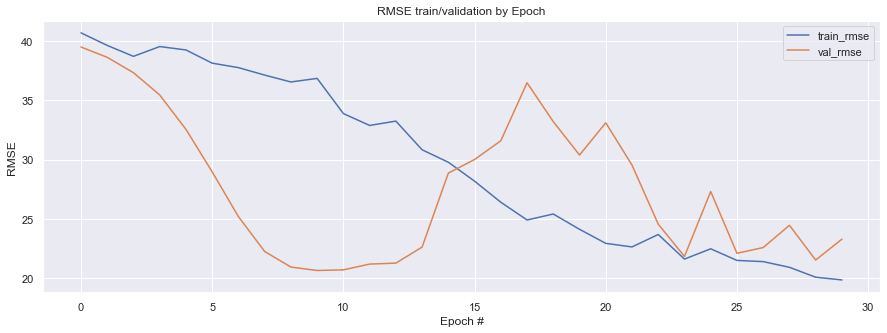

In [52]:
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right");

Just out of curiosity, I plotted one of these "images" and as expected, they aren't so much human-parsable anymore, though we do see that they tend to start more black and white and become more and more gray toward the bottom.

(-0.5, 17.5, 17.5, -0.5)

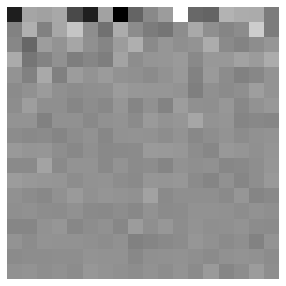

In [53]:
plt.imshow(train_pca[108].reshape(18,18), cmap='gray')
plt.axis('off')

This works reasonably well! We will now use the dev set to optimize parameters and a bit of layer structure, first by generalizing the model building, then iterating through different combinations.

In [54]:
def get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5, 
             kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7):
    tf.keras.backend.clear_session()
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    input_shape = (18, 18, 1)
    
    X_input = keras.layers.Input(input_shape)

    x = (keras.layers.Conv2D(ks_1, kernel_size=ks_1,
                      padding='same',
                      activation='relu'))(X_input)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)

    x = keras.layers.MaxPooling2D(pool_size=2)(x)

    x = keras.layers.Conv2D(ks_2, kernel_size=ks_2,
                      padding='same',
                      activation='relu')(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Dropout(mid_drop)(x)

    x = keras.layers.MaxPooling2D(pool_size=2)(x)

    x = keras.layers.Conv2D(ks_3, kernel_size=ks_3,
                      padding='same',
                      activation='relu')(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Activation('relu')(x)

    x = keras.layers.MaxPooling2D(pool_size=2)(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(mid_drop)(x)

    x = keras.layers.Conv2D(ks_4, kernel_size=ks_4,
                      padding='same',
                      activation='relu')(x)

    # Max-Pooling
    x = keras.layers.MaxPooling2D(pool_size=2)(x)

    x = keras.layers.Conv2D(ks_5, kernel_size=ks_5,
                      padding='same',
                      activation='relu')(x)

    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dropout(mid_drop)(x)

    x = keras.layers.Flatten()(x)

    x = keras.layers.Dense(first_dense, activation='relu')(x)
    
    x = keras.layers.Dense(first_dense/dense_decay, activation='relu')(x)
    
    if extra_dense == 1:
        x = keras.layers.Dense((first_dense/dense_decay)/dense_decay, activation='relu')(x)

    x = keras.layers.Dropout(final_drop)(x)

    # output regression results
    output = keras.layers.Dense(1)(x)

    cnn_model_1 = keras.Model(inputs = X_input, outputs = output)

    model = keras.Model(inputs = X_input, outputs = output)
    
    return model

We're going to do tuning in steps--although not everything is independent, neither is everything simultaneously tunable. We'll start with tuning drops:

<i>Quick note: This was an 11th-hour addition, so it's not as refined or clean as it otherwise might be, but we thought it was worth showing.

In [58]:
score = 100
best_model = 0

#         for first_dense in [512,256,128,64,32]:
#         for dense_decay in [2,3,4,6,8]:
for final_drop in [0.2,0.3,0.4,0.5,0.6]:
    for mid_drop in [0.1,0.2,0.3,0.4,0.5]:
        extra_dense = 1
        first_dense = 128
        dense_decay = 2
        ks_1 = 8
        ks_2 = 6
        ks_3 = 4
        ks_4 = 3
        ks_5 = 2
        kc_1 = 32
        kc_2 = 32
        kc_3 = 64
        kc_4 = 64
        kc_5 = 128

        current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

        # compile the model
        current_model.compile(
            loss = 'mse', 
            optimizer = 'Adam', 
            metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

        # data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
        #     height_shift_range = 0.5, 
        #     shear_range = 0.5,
        #     horizontal_flip = True, 
        #     fill_mode = "nearest")

        kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

        history = current_model.fit(
            x_dev,dev_labels,batch_size=256,
            validation_data = (x_test,test_labels),
            steps_per_epoch = len(x_dev) // 256,
            epochs = 600, callbacks=[kall],
            verbose = 0
        )
        if min(history.history["val_rmse"]) < score:
            score = min(history.history["val_rmse"])
            best_model = current_model
            print("="*60)
            print("A new high score! Score:",score)
            print("Best parameters so far:")
            print("first_dense, dense_decay, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5")
            print(first_dense, dense_decay, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5)



A new high score! Score: 19.202796936035156
Best parameters so far:
first_dense, dense_decay, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
128 2 0.2 0.1 8 6 4 3 2 32 32 64 64 128
A new high score! Score: 18.83161163330078
Best parameters so far:
first_dense, dense_decay, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
128 2 0.2 0.2 8 6 4 3 2 32 32 64 64 128
A new high score! Score: 18.61110496520996
Best parameters so far:
first_dense, dense_decay, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
128 2 0.2 0.3 8 6 4 3 2 32 32 64 64 128
A new high score! Score: 18.591815948486328
Best parameters so far:
first_dense, dense_decay, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
128 2 0.2 0.4 8 6 4 3 2 32 32 64 64 128
A new high score! Score: 18.491268157958984
Best parameters so far:
first_dense, dense_decay, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,k

That gave us final drop of 0.2 and mid-drops of 0.5. Next, dense layer number/parameters:

In [59]:
score = 100
best_model = 0

for first_dense in [512,256,128,64,32]:
    for dense_decay in [2,3,4,6,8]:
        for extra_dense in [0,1]:
            final_drop = 0.2
            mid_drop = 0.5
            ks_1 = 8
            ks_2 = 6
            ks_3 = 4
            ks_4 = 3
            ks_5 = 2
            kc_1 = 32
            kc_2 = 32
            kc_3 = 64
            kc_4 = 64
            kc_5 = 128

            current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

            # compile the model
            current_model.compile(
                loss = 'mse', 
                optimizer = 'Adam', 
                metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

            # data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
            #     height_shift_range = 0.5, 
            #     shear_range = 0.5,
            #     horizontal_flip = True, 
            #     fill_mode = "nearest")

            kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

            history = current_model.fit(
                x_dev,dev_labels,batch_size=256,
                validation_data = (x_test,test_labels),
                steps_per_epoch = len(x_dev) // 256,
                epochs = 600, callbacks=[kall],
                verbose = 0
            )
            if min(history.history["val_rmse"]) < score:
                score = min(history.history["val_rmse"])
                best_model = current_model
                print("="*60)
                print("A new high score! Score:",score)
                print("Best parameters so far:")
                print("first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5")
                print(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5)

A new high score! Score: 18.47756004333496
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
512 2 0 0.2 0.5 8 6 4 3 2 32 32 64 64 128
A new high score! Score: 18.47576904296875
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
512 2 1 0.2 0.5 8 6 4 3 2 32 32 64 64 128
A new high score! Score: 18.47528076171875
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
512 3 0 0.2 0.5 8 6 4 3 2 32 32 64 64 128
A new high score! Score: 18.473360061645508
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 8 6 4 3 2 32 32 64 64 128


Those vary by run, but we'll call it 256 and 2 for first dense layer size and decay factor. Next we will go through each kernel size and filter counts on the convolution layers, starting with the first:

In [60]:
score = 100
best_model = 0
for ks_1 in [2,3,4,5]:
    for kc_1 in [8,16,32,64,128]:
        first_dense = 256
        dense_decay = 2
        extra_dense = 1
        final_drop = 0.2
        mid_drop = 0.5
        ks_2 = 6
        ks_3 = 4
        ks_4 = 3
        ks_5 = 2
        kc_2 = 32
        kc_3 = 64
        kc_4 = 64
        kc_5 = 128

        current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

        # compile the model
        current_model.compile(
            loss = 'mse', 
            optimizer = 'Adam', 
            metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

        # data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
        #     height_shift_range = 0.5, 
        #     shear_range = 0.5,
        #     horizontal_flip = True, 
        #     fill_mode = "nearest")

        kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

        history = current_model.fit(
            x_dev,dev_labels,batch_size=256,
            validation_data = (x_test,test_labels),
            steps_per_epoch = len(x_dev) // 256,
            epochs = 600, callbacks=[kall],
            verbose = 0
        )
        if min(history.history["val_rmse"]) < score:
            score = min(history.history["val_rmse"])
            best_model = current_model
            print("="*60)
            print("A new high score! Score:",score)
            print("Best parameters so far:")
            print("first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5")
            print(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5)

A new high score! Score: 18.47596549987793
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 2 6 4 3 2 8 32 64 64 128
A new high score! Score: 18.47571563720703
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 3 6 4 3 2 8 32 64 64 128


These also vary by run, so I'll list at least one set of winning values (in this case, kernel size 4 with 8 filters).

In [61]:
score = 100
best_model = 0
for ks_2 in [2,3,4,5]:
    for kc_2 in [8,16,32,64,128]:
        first_dense = 256
        dense_decay = 2
        extra_dense = 1
        final_drop = 0.2
        mid_drop = 0.5
        ks_1 = 4
        ks_3 = 4
        ks_4 = 3
        ks_5 = 2
        kc_1 = 8
        kc_3 = 64
        kc_4 = 64
        kc_5 = 128

        current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

        # compile the model
        current_model.compile(
            loss = 'mse', 
            optimizer = 'Adam', 
            metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

        # data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
        #     height_shift_range = 0.5, 
        #     shear_range = 0.5,
        #     horizontal_flip = True, 
        #     fill_mode = "nearest")

        kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

        history = current_model.fit(
            x_dev,dev_labels,batch_size=256,
            validation_data = (x_test,test_labels),
            steps_per_epoch = len(x_dev) // 256,
            epochs = 600, callbacks=[kall],
            verbose = 0
        )
        if min(history.history["val_rmse"]) < score:
            score = min(history.history["val_rmse"])
            best_model = current_model
            print("="*60)
            print("A new high score! Score:",score)
            print("Best parameters so far:")
            print("first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5")
            print(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5)

A new high score! Score: 18.479318618774414
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 2 4 3 2 8 8 64 64 128
A new high score! Score: 18.475967407226562
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 3 4 3 2 8 8 64 64 128
A new high score! Score: 18.474353790283203
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 4 3 2 8 8 64 64 128


On that run, size 5 with 64 filters won for the second convolution layer.

In [62]:
score = 100
best_model = 0
for ks_3 in [2,3,4,5]:
    for kc_3 in [8,16,32,64,128]:
        first_dense = 256
        dense_decay = 2
        extra_dense = 1
        final_drop = 0.2
        mid_drop = 0.5
        ks_1 = 4
        ks_2 = 5
        ks_4 = 3
        ks_5 = 2
        kc_1 = 8
        kc_2 = 64
        kc_4 = 64
        kc_5 = 128

        current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

        # compile the model
        current_model.compile(
            loss = 'mse', 
            optimizer = 'Adam', 
            metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

        # data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
        #     height_shift_range = 0.5, 
        #     shear_range = 0.5,
        #     horizontal_flip = True, 
        #     fill_mode = "nearest")

        kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

        history = current_model.fit(
            x_dev,dev_labels,batch_size=256,
            validation_data = (x_test,test_labels),
            steps_per_epoch = len(x_dev) // 256,
            epochs = 600, callbacks=[kall],
            verbose = 0
        )
        if min(history.history["val_rmse"]) < score:
            score = min(history.history["val_rmse"])
            best_model = current_model
            print("="*60)
            print("A new high score! Score:",score)
            print("Best parameters so far:")
            print("first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5")
            print(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5)

A new high score! Score: 18.475975036621094
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 2 3 2 8 64 8 64 128
A new high score! Score: 18.474353790283203
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 4 3 2 8 64 8 64 128


For that run, kernel size of 4 with 32 filters did best on layer 3.

In [63]:
score = 100
best_model = 0
for ks_4 in [2,3,4,5]:
    for kc_4 in [8,16,32,64,128]:
        first_dense = 256
        dense_decay = 2
        extra_dense = 1
        final_drop = 0.2
        mid_drop = 0.5
        ks_1 = 4
        ks_2 = 5
        ks_3 = 4
        ks_5 = 2
        kc_1 = 8
        kc_2 = 64
        kc_3 = 32
        kc_5 = 128

        current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

        # compile the model
        current_model.compile(
            loss = 'mse', 
            optimizer = 'Adam', 
            metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

        # data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
        #     height_shift_range = 0.5, 
        #     shear_range = 0.5,
        #     horizontal_flip = True, 
        #     fill_mode = "nearest")

        kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

        history = current_model.fit(
            x_dev,dev_labels,batch_size=256,
            validation_data = (x_test,test_labels),
            steps_per_epoch = len(x_dev) // 256,
            epochs = 600, callbacks=[kall],
            verbose = 0
        )
        if min(history.history["val_rmse"]) < score:
            score = min(history.history["val_rmse"])
            best_model = current_model
            print("="*60)
            print("A new high score! Score:",score)
            print("Best parameters so far:")
            print("first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5")
            print(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5)

A new high score! Score: 18.477001190185547
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 4 2 2 8 64 32 8 128
A new high score! Score: 18.474353790283203
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 4 3 2 8 64 32 8 128


For layer 4, we saw best results with kernel size 5 and 8 filters.

In [64]:
score = 100
best_model = 0
for ks_5 in [2,3,4,5]:
    for kc_5 in [8,16,32,64,128]:
        first_dense = 256
        dense_decay = 2
        extra_dense = 1
        final_drop = 0.2
        mid_drop = 0.5
        ks_1 = 4
        ks_2 = 5
        ks_3 = 4
        ks_4 = 5
        kc_1 = 8
        kc_2 = 64
        kc_3 = 32
        kc_4 = 8

        current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

        # compile the model
        current_model.compile(
            loss = 'mse', 
            optimizer = 'Adam', 
            metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

        # data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
        #     height_shift_range = 0.5, 
        #     shear_range = 0.5,
        #     horizontal_flip = True, 
        #     fill_mode = "nearest")

        kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

        history = current_model.fit(
            x_dev,dev_labels,batch_size=256,
            validation_data = (x_test,test_labels),
            steps_per_epoch = len(x_dev) // 256,
            epochs = 600, callbacks=[kall],
            verbose = 0
        )
        if min(history.history["val_rmse"]) < score:
            score = min(history.history["val_rmse"])
            best_model = current_model
            print("="*60)
            print("A new high score! Score:",score)
            print("Best parameters so far:")
            print("first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5")
            print(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5)

A new high score! Score: 18.476694107055664
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 4 5 2 8 64 32 8 8
A new high score! Score: 18.476152420043945
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 4 5 3 8 64 32 8 8
A new high score! Score: 18.475967407226562
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 4 5 4 8 64 32 8 8
A new high score! Score: 18.46721839904785
Best parameters so far:
first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5
256 2 1 0.2 0.5 4 5 4 5 5 8 64 32 8 8


For the last convolution layer, we saw best results again with size 2 and 32 filters.

Lastly, we will compare performance with and without the augmentation object which looks for rotated/zoomed/flipped versions using the same filter banks. First, performance without:

In [65]:
score = 100
best_model = 0

first_dense = 256
dense_decay = 2
extra_dense = 1
final_drop = 0.2
mid_drop = 0.5
ks_1 = 4
ks_2 = 5
ks_3 = 4
ks_4 = 5
ks_5 = 2
kc_1 = 8
kc_2 = 64
kc_3 = 32
kc_4 = 8
kc_5 = 32

current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

# compile the model
current_model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

history = current_model.fit(
    x_dev,dev_labels,batch_size=256,
    validation_data = (x_test,test_labels),
    steps_per_epoch = len(x_dev) // 256,
    epochs = 600, callbacks=[kall],
)

print("Best score without augmentations:", min(history.history["val_rmse"]))

Epoch 1/600
3/3 [==============================] - 1s 169ms/step - loss: 1547.3431 - rmse: 39.3363 - val_loss: 1639.1783 - val_rmse: 40.4868
Epoch 2/600
3/3 [==============================] - 0s 85ms/step - loss: 1633.7366 - rmse: 40.4195 - val_loss: 1635.8594 - val_rmse: 40.4458
Epoch 3/600
3/3 [==============================] - 0s 96ms/step - loss: 1519.7653 - rmse: 38.9842 - val_loss: 1631.1915 - val_rmse: 40.3880
Epoch 4/600
3/3 [==============================] - 0s 96ms/step - loss: 1559.3687 - rmse: 39.4888 - val_loss: 1624.6805 - val_rmse: 40.3073
Epoch 5/600
3/3 [==============================] - 0s 86ms/step - loss: 1543.0497 - rmse: 39.2817 - val_loss: 1615.4348 - val_rmse: 40.1925
Epoch 6/600
3/3 [==============================] - 0s 94ms/step - loss: 1505.4264 - rmse: 38.7998 - val_loss: 1602.3976 - val_rmse: 40.0300
Epoch 7/600
3/3 [==============================] - 0s 85ms/step - loss: 1520.1725 - rmse: 38.9894 - val_loss: 1583.9164 - val_rmse: 39.7984
Epoch 8/600
3/3 [==

Epoch 60/600
3/3 [==============================] - 0s 82ms/step - loss: 300.7318 - rmse: 17.3416 - val_loss: 343.0491 - val_rmse: 18.5216
Epoch 61/600
3/3 [==============================] - 0s 100ms/step - loss: 303.3723 - rmse: 17.4176 - val_loss: 343.8452 - val_rmse: 18.5431
Epoch 62/600
3/3 [==============================] - 0s 89ms/step - loss: 311.2001 - rmse: 17.6409 - val_loss: 343.6932 - val_rmse: 18.5390
Epoch 63/600
3/3 [==============================] - 0s 80ms/step - loss: 316.8955 - rmse: 17.8016 - val_loss: 343.0763 - val_rmse: 18.5223
Epoch 64/600
3/3 [==============================] - 0s 87ms/step - loss: 312.3911 - rmse: 17.6746 - val_loss: 342.7238 - val_rmse: 18.5128
Epoch 65/600
3/3 [==============================] - 0s 90ms/step - loss: 305.1053 - rmse: 17.4673 - val_loss: 342.2934 - val_rmse: 18.5012
Epoch 66/600
3/3 [==============================] - 0s 94ms/step - loss: 318.5230 - rmse: 17.8472 - val_loss: 341.8479 - val_rmse: 18.4891
Epoch 67/600
3/3 [========

We performed at RMSE 18.476 without augmentations.

In [66]:
score = 100
best_model = 0

current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
    height_shift_range = 0.5, 
    shear_range = 0.5,
    horizontal_flip = True, 
    fill_mode = "nearest")

# compile the model
current_model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=20,restore_best_weights=True)

history = current_model.fit(
    data_augmentation.flow(x_dev,dev_labels,batch_size=256),
    validation_data = (x_test,test_labels),
    steps_per_epoch = len(x_dev) // 256,
    epochs = 600, callbacks=[kall],
)

print("Best score with augmentations:", min(history.history["val_rmse"]))

Epoch 1/600
3/3 [==============================] - 1s 204ms/step - loss: 1589.7992 - rmse: 39.8723 - val_loss: 1639.1210 - val_rmse: 40.4861
Epoch 2/600
3/3 [==============================] - 0s 131ms/step - loss: 1548.7850 - rmse: 39.3546 - val_loss: 1635.7794 - val_rmse: 40.4448
Epoch 3/600
3/3 [==============================] - 0s 130ms/step - loss: 1496.7338 - rmse: 38.6876 - val_loss: 1630.8820 - val_rmse: 40.3842
Epoch 4/600
3/3 [==============================] - 0s 152ms/step - loss: 1567.4203 - rmse: 39.5907 - val_loss: 1623.8490 - val_rmse: 40.2970
Epoch 5/600
3/3 [==============================] - 0s 124ms/step - loss: 1562.5201 - rmse: 39.5287 - val_loss: 1613.9381 - val_rmse: 40.1738
Epoch 6/600
3/3 [==============================] - 0s 143ms/step - loss: 1527.1870 - rmse: 39.0792 - val_loss: 1600.0090 - val_rmse: 40.0001
Epoch 7/600
3/3 [==============================] - 0s 147ms/step - loss: 1475.7606 - rmse: 38.4156 - val_loss: 1580.4075 - val_rmse: 39.7543
Epoch 8/600
3

Including augmentations, we got that down to 18.475. Let us again train using the full set and evaluate.

In [67]:
current_model = get_model(first_dense, dense_decay, extra_dense, final_drop, mid_drop, ks_1, ks_2, ks_3, ks_4, ks_5,kc_1, kc_2, kc_3, kc_4, kc_5, SEED=7)

data_augmentation = ImageDataGenerator(rotation_range=45, zoom_range=0.9, width_shift_range = 0.5, 
    height_shift_range = 0.5, 
    shear_range = 0.5,
    horizontal_flip = True, 
    fill_mode = "nearest")

# compile the model
current_model.compile(
    loss = 'mse', 
    optimizer = 'Adam', 
    metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)

history = current_model.fit(
    data_augmentation.flow(x_train,train_labels,batch_size=256),
    validation_data = (x_test,test_labels),
    steps_per_epoch = len(x_train) // 256,
    epochs = 600, callbacks=[kall],
)

print("Best score:", min(history.history["val_rmse"]))

Epoch 1/600
30/30 [==============================] - 4s 111ms/step - loss: 1541.4299 - rmse: 39.2610 - val_loss: 1467.6111 - val_rmse: 38.3094
Epoch 2/600
30/30 [==============================] - 3s 103ms/step - loss: 834.4728 - rmse: 28.8872 - val_loss: 540.2563 - val_rmse: 23.2434
Epoch 3/600
30/30 [==============================] - 3s 93ms/step - loss: 430.2881 - rmse: 20.7434 - val_loss: 362.7148 - val_rmse: 19.0451
Epoch 4/600
30/30 [==============================] - 3s 105ms/step - loss: 357.5775 - rmse: 18.9097 - val_loss: 346.2554 - val_rmse: 18.6079
Epoch 5/600
30/30 [==============================] - 3s 99ms/step - loss: 341.4279 - rmse: 18.4778 - val_loss: 344.7651 - val_rmse: 18.5679
Epoch 6/600
30/30 [==============================] - 3s 97ms/step - loss: 335.5211 - rmse: 18.3172 - val_loss: 341.3173 - val_rmse: 18.4748
Epoch 7/600
30/30 [==============================] - 3s 96ms/step - loss: 332.7406 - rmse: 18.2412 - val_loss: 341.5038 - val_rmse: 18.4798
Epoch 8/600
30/

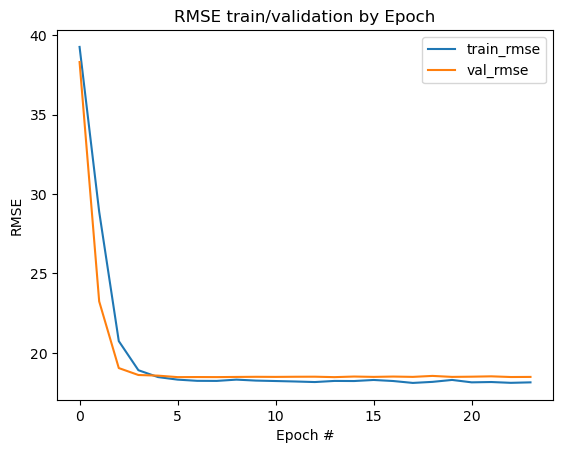

In [68]:
plt.style.use('default')
plt.figure()
plt.plot(history.history["rmse"], label="train_rmse")
plt.plot(history.history["val_rmse"], label="val_rmse")
plt.title("RMSE train/validation by Epoch")
plt.xlabel("Epoch #")
plt.ylabel("RMSE")
plt.legend(loc="upper right");

Performance using the full set is the same: RMSE 18.476, which does not quite match our ensemble model with the combined data above.

We did explore other methods, some of which are included below. The very best performance we managed was using the full color images in an EfficientNet b3 model combined with Light GBM with the tabular data. That extra depth gained us an RMSE reduction of 1.9, but came at the cost of much, much longer training time.

## Part VII: Conclusion

### - Best scoring model:
At the time of our baseline submission, our best scoring model was the KNN Regression Model on pixel data scoring RMSE = 18.4098. We had only explored Linear Regression Models and KNN Regression Models at the time. Since then, we have explored Decision Trees (and Random Forest Ensembles), Histogram-based Gradient Boosting Models, and CNN Models.

Post our baseline submission, the best overall scoring model turned out to be Random Forest with a RMSE of 17.8775 that outperformed the Histogram-based Gradient Boosting Model with a less performative RMSE of 18.2999. It is also worth noticing that about 47.48% of the predicted labels are within 10 points of the correct label for Random Forest compared to the 47.06% of the LR-predicted labels being within 10 of the correct label for the Histogram-based Gradient Boosting model. Surprisingly, the CNN model didn't perform as well as we expected despite the amount of iterations we made on the kernel size and filters per layer.

### - Limitations:

There were a fair amount of challenges with the "Pawpularity" Contest Kaggle Competition such as the following: Understanding what the image scores really meant, How to go about transforming and pre-processing the images to a state that can utilized within the models, Creating the high-performing models itself, Defining the CNN model architecture especially when it come to how many kernels and filters should be needed within each layer for the best performance, and accurately predicting the Pawpularity Scores just based on the images alone.

As for surprises, there seemed to be some unexpected skews within the tabular distribution data that we needed to remove for higher performance, the lowest RMSE score happened to be Random Forest and not the CNN model, there were no insights provided as to how people scored, there were a lack of results from the CNN model, and there happened to be a similar distribution for Pawpularity scores for each variable.

When it came to the methods used for this competition, the following were utilized starting from the initial EDA all the way to the creation and processing of our models: Digit Classification, PCA, Flattening/Padding, KNN, Linear Regression, CNN, Random Forest, Decision Tree, and packages such as tensforflow/scikit/sklearn/matplotlib.

### - Missing Data/Noise:

As mentioned above, there were a lack of insights on how people scored "Pawpularity" which led us to making some assumptions about the type of scores that were provided. There were also no information provided on the logistics behind the Petfinder.my website such as how traffic is being handled in the backend along with lack of external influential factors being provided such as the # of clicks per pet.

And lastly for noise, there were some distribution skews in the amount of pawpularity scores on end both ends of the spectrum which needed to be removed for higher performance along with some pet photos having unnecessary background items and colors which was removed as well.

## Appendix 1: CNN Model without PCA

<i>Note well: all code has been run and works, but much of it takes long enough to run that it was not worth re-running. Some of it was run in Jupyter, others in another IDE.

### CNN Pre-Processing

In [69]:
# # Re-modifying the Id such that each Id is the full image path
# def train_id_to_path(x):
#     return './train/' + x + ".jpg"
# def test_id_to_path(x):
#     return './test/' + x + ".jpg"

In [70]:
# # Re-reading in the data and drop unnecessary columns
# train = pd.read_csv('./train.csv')
# train = train[train['Pawpularity'] != 100].reset_index()
# train = train.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

# test = pd.read_csv('./test.csv')
# test = test.drop(['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory', 'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur'],axis=1)

In [71]:
# # Adding the .jpg extensions to the image file name ids
# train["img_path"] = train["Id"].apply(train_id_to_path)
# test["img_path"] = test["Id"].apply(test_id_to_path)

In [72]:
# # Set the size image (constraining to square)
# image_dim = 128

# # Define a function that accepts an image url and outputs an eager tensor
# def path_to_eagertensor(image_path, image_dim):
#     raw = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(raw, channels=3)
#     image = tf.cast(image, tf.float32) / 255.0
#     image = tf.image.resize(image, (image_dim, image_dim))
#     return image

In [73]:
# # Obtain all images in the training folder and put their tensors in a list
# def build_tensor_list(image_dim):
#     X = []
#     for img in tqdm(train['img_path']):
#         new_img_tensor = path_to_eagertensor(img, image_dim)
#         X.append(new_img_tensor)
#     X = np.array(X)
#     return X
    
# X = build_tensor_list(image_dim)
    
# print(type(X),X.shape)

In [74]:
# # Setting our train target y to be the Pawpularity score
# Y = train['Pawpularity']

In [75]:
# # divide into train/dev/test sets

# train_array, rem_array, train_labels, rem_labels = train_test_split(X, Y, train_size = .8, random_state = 7)
# dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)

# print("Training shape:", (train_array.shape), (train_labels.shape))
# print("Dev shape:", (dev_array.shape), (dev_labels.shape))
# print("Test shape:", (test_array.shape), (test_labels.shape))

### CNN Model from image data

In [76]:
# def get_model(SEED=7):
#     tf.keras.backend.clear_session()
#     np.random.seed(SEED)
#     tf.random.set_seed(SEED)
    
#     input_ = keras.Input(shape=(X.shape[1],X.shape[2],3))

#     x = keras.layers.Conv2D(filters = 16, kernel_size=7, strides=2, padding='valid', kernel_initializer='he_normal',
#                            kernel_regularizer=l2(0.0005), activation = 'relu')(input_)

#     x = keras.layers.Conv2D(filters = 32, kernel_size=3, padding='same', kernel_initializer='he_normal',
#                            activation = 'relu')(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.Conv2D(filters = 32, kernel_size=3,strides=2, padding='same', kernel_initializer='he_normal',
#                            activation = 'relu', kernel_regularizer=l2(0.0005))(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.Dropout(0.25)(x)

#     x = keras.layers.Conv2D(filters = 64, kernel_size=3, padding='same', kernel_initializer='he_normal', activation='relu'
#                             ,kernel_regularizer=l2(0.0002))(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.Conv2D(filters = 64, kernel_size = 3, strides = 2, padding='same',
#                                kernel_initializer='he_normal', kernel_regularizer=l2(0.0005), activation = 'relu')(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.Dropout(0.25)(x)

#     #####
#     x = keras.layers.Conv2D(filters = 128, kernel_size = 3, padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

#     x = keras.layers.Conv2D(filters = 128, kernel_size = 3,padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.0002), activation = 'relu')(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.Dropout(0.25)(x)

#     x = keras.layers.Flatten()(x)

#     x = keras.layers.Dense(512, activation = "relu")(x)

#     x = keras.layers.Dropout(0.5)(x)

#     output = keras.layers.Dense(1)(x)

#     model = keras.Model(inputs = input_, outputs = output)
    
#     return model

In [77]:
# model = get_model()
# model.summary()

In [78]:
# #compile the model
# model.compile(
#     loss = 'mse', 
#     optimizer = 'Adam', 
#     metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [79]:
# data_augmentation = ImageDataGenerator(rotation_range=40, zoom_range=0.3, width_shift_range = 0.3, 
#     height_shift_range = 0.3, 
#     shear_range = 0.3,
#     horizontal_flip = True, 
#     fill_mode = "nearest")

In [80]:
# kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)

# history = model.fit(
#     data_augmentation.flow(train_array,train_labels,batch_size=128),
#     validation_data = (test_array,test_labels),
#     steps_per_epoch = len(train_array) // 1024,
#     epochs = 600, callbacks=[kall]
# )

In [81]:
# plt.figure()
# plt.plot(history.history["rmse"], label="train_rmse")
# plt.plot(history.history["val_rmse"], label="val_rmse")
# plt.title("RMSE train/validation by Epoch")
# plt.xlabel("Epoch #")
# plt.ylabel("RMSE")
# plt.legend(loc="upper right");

In [82]:
# # Predict on the submission data
# cnn_pred = model.predict(X_submission)
# print(X_submission.shape, type(X_submission))
# print(cnn_pred.shape, type(cnn_pred))

So our first-draft model works, though not significantly better than previous attempts. In order to improve performance, we will work on tuning hyperparameters. In this case, these fall into several categories: input image size, model parameters (dropout, layer structure, number of filters, kernel size), and augmentation settings (rotation range, zoom range, width/height shift range).

Because the number of filters and kernel size are not independent from the image size, these will be tuned with many combinations. However, augmentation settings should be largely independent and will be tuned separately.

First, we will set up helper functions to make things easier/more readable. Then we will iterate through hyperparameters to improve the model's performance. (Quick note: even with pre-set random states, the training can occasionally result in different values than were previously obtained, so the markup cells will contain the best result from when we ran this, but they won't necessarily be the best in your run, especially if they are close).

In [83]:
# # Define a function that accepts an image url and outputs an eager tensor
# def path_to_eagertensor(image_path, image_dim, pad):
#     raw = tf.io.read_file(image_path)
#     image = tf.image.decode_jpeg(raw, channels=3)
#     image = tf.cast(image, tf.float32) / 255.0
#     if pad == 1:
#         image = tf.image.resize_with_pad(image, image_dim, image_dim)
#     else:
#         image = tf.image.resize(image, (image_dim, image_dim))
#     return image

# def build_tensor_list(image_dim, pad):
#     X = []
#     for img in tqdm(train['img_path']):
#         new_img_tensor = path_to_eagertensor(img, image_dim, pad)
#         X.append(new_img_tensor)
#     X = np.array(X)
#     return X

# def configure_datasets(image_dim, pad=0): 
#     X = build_tensor_list(image_dim, pad)
#     Y = train['Pawpularity']
#     train_array, rem_array, train_labels, rem_labels = train_test_split(X, Y, train_size = .8, random_state = 7)
#     dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)
#     return X, Y, train_array, train_labels, test_array, test_labels, dev_array, dev_labels
    
# def get_model(SEED=7, mid_drop=0.25, n_filter_factor=16, kernel_size_factor=32, layer_sets=4, image_dim=128, dense=512):
#     tf.keras.backend.clear_session()
#     np.random.seed(SEED)
#     tf.random.set_seed(SEED)
#     n_filters = image_dim/(n_filter_factor)
#     k_l = int(round(image_dim/(kernel_size_factor), 0)) # (kernel "large")
#     k_s = max(int(round(k_l/2, 0)),1) # (kernel "small")
    
#     input_ = keras.Input(shape=(X.shape[1],X.shape[2],3))

#     x = keras.layers.Conv2D(filters = n_filters, kernel_size=k_l, strides=[2,2], padding='valid', kernel_initializer='he_normal',
#                            kernel_regularizer=l2(0.0005), activation = 'relu')(input_)
#     x = keras.layers.Conv2D(filters = 2*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal',
#                            activation = 'relu')(x)
#     x = keras.layers.BatchNormalization()(x)
#     x = keras.layers.Conv2D(filters = 2*n_filters, kernel_size=k_s,strides=[2,2], padding='same', kernel_initializer='he_normal',
#                            activation = 'relu', kernel_regularizer=l2(0.0005))(x)
#     x = keras.layers.BatchNormalization()(x)
    
#     x = keras.layers.Dropout(mid_drop)(x)
    
#     x = keras.layers.Conv2D(filters = 4*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal', 
#                             activation='relu', kernel_regularizer=l2(0.0002))(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.Conv2D(filters = 4*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal', 
#                             activation='relu', kernel_regularizer=l2(0.0002))(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.Dropout(mid_drop)(x)

#     x = keras.layers.Conv2D(filters = 8*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal', 
#                             activation='relu', kernel_regularizer=l2(0.0002))(x)

#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.MaxPooling2D(pool_size=k_s)(x)

#     x = keras.layers.Conv2D(filters = 8*n_filters, kernel_size=k_s, padding='same', kernel_initializer='he_normal', 
#                             activation='relu', kernel_regularizer=l2(0.0002))(x)
        
#     x = keras.layers.BatchNormalization()(x)

#     x = keras.layers.Dropout(mid_drop)(x)

#     x = keras.layers.Flatten()(x)

#     x = keras.layers.Dense(dense, activation = "relu")(x)

#     x = keras.layers.Dropout(2*mid_drop)(x)

#     output = keras.layers.Dense(1)(x)
#     model = keras.Model(inputs = input_, outputs = output)
    
#     return model

We will first test whether resizing or padding performs better.

In [84]:
# for pad in [0,1]:
#     print("="*60)
#     print("Now testing padding. Resizing images for the model...", sep="")
#     image_dim = 128
#     X, Y, train_array, train_labels, test_array, test_labels, dev_array, dev_labels = configure_datasets(image_dim=image_dim, pad=pad)
#     model = get_model(mid_drop=0.25, n_filter_factor=8, kernel_size_factor=16, layer_sets=4, image_dim=image_dim, dense=512)
#     model.compile(
#         loss = 'mse', 
#         optimizer = 'Adam', 
#         metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
#     kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
#     print("Done resizing. Now fitting model (verbose output deactivated, please be patient).")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=512),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 512,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For pad =",pad,"best score is",min(current_model.history["val_rmse"]))

Padding appears to slightly outperform resizing. 

In [85]:
# pad = 1

# for image_dim in [20,25,30,40,50,80,100,140,180,240]:
#     print("="*60)
#     print("Now testing image size ", image_dim,"x",image_dim,". Resizing images for the model...", sep="")
#     X, Y, train_array, train_labels, test_array, test_labels, dev_array, dev_labels = configure_datasets(image_dim=image_dim, pad=pad)
#     model = get_model(mid_drop=0.25, n_filter_factor=8, kernel_size_factor=16, layer_sets=4, image_dim=image_dim)
#     model.compile(
#         loss = 'mse', 
#         optimizer = 'Adam', 
#         metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
#     kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
#     print("Done resizing. Now fitting model (verbose output deactivated, please be patient).")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=128),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 128,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For image dim = ",image_dim,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

It's VERY close, but we are seeing the best performance around image size 140x140, so we will use that going forward.

In [86]:
# pad = 1
# image_dim = 140

# X, Y, train_array, train_labels, test_array, test_labels, dev_array, dev_labels = configure_datasets(image_dim=image_dim, pad=pad)
# model = get_model(mid_drop=0.25, n_filter_factor=8, kernel_size_factor=16, layer_sets=4, image_dim=image_dim)
# model.compile(
#     loss = 'mse', 
#     optimizer = 'Adam', 
#     metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
# kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)

# for rotation_range in [10,20,30,40,45,50]:
#     print("="*60)
#     print("Now testing rotation range ", rotation_range, sep="")
#     print("Now fitting model (verbose output deactivated, please be patient).")
#     data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=0.3, width_shift_range = 0.3, 
#                                             height_shift_range = 0.3, 
#                                             shear_range = 0.3,
#                                             horizontal_flip = True, 
#                                             fill_mode = "nearest")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=128),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 128,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For rotation range = ",rotation_range,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Best rotation range: 45

In [87]:
# pad = 1
# image_dim = 140
# rotation_range = 45
# current_param = "zoom range"

# for zoom_range in [0.1,0.3,0.5,0.7,0.9]:
#     print("="*60)
#     print("Now testing ",current_param," ",zoom_range, sep="")
#     print("Now fitting model (verbose output deactivated, please be patient).")
#     data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = 0.3, 
#                                             height_shift_range = 0.3, 
#                                             shear_range = 0.3,
#                                             horizontal_flip = True, 
#                                             fill_mode = "nearest")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=128),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 128,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For ",current_param," ",zoom_range,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

In [88]:
# pad = 1
# image_dim = 140
# rotation_range = 45
# zoom_range = 0.9
# current_param = "shift/shear range"

# for shift_range in [0.1,0.3,0.5,0.7,0.9]:
#     print("="*60)
#     print("Now testing ",current_param," ",shift_range,"." sep="")
#     print("Now fitting model (verbose output deactivated, please be patient).")
#     data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
#                                             height_shift_range = shift_range, 
#                                             shear_range = shift_range,
#                                             horizontal_flip = True, 
#                                             fill_mode = "nearest")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=128),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 128,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For ",current_param," ",shift_range,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Best shift/shear range: 0.5

In [89]:
# pad = 1
# image_dim = 140
# rotation_range = 45
# zoom_range = 0.9
# shift_range = 0.5
# current_param = "mid-model drop percentage"


# data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
#                                         height_shift_range = shift_range, 
#                                         shear_range = shift_range,
#                                         horizontal_flip = True, 
#                                         fill_mode = "nearest")

# for mid_drop in [0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.3, 0.35, 0.4]:
#     print("="*60)
#     print("Now testing ",current_param," ",mid_drop,".", sep="")
#     model = get_model(mid_drop=mid_drop, n_filter_factor=8, kernel_size_factor=16, image_dim=image_dim)
#     model.compile(
#         loss = 'mse', 
#         optimizer = 'Adam', 
#         metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
#     kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
#     print("Now fitting model (verbose output deactivated, please be patient).")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=128),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 128,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For ",current_param," = ",mid_drop,", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

In [90]:
# pad = 1
# image_dim = 140
# rotation_range = 45
# zoom_range = 0.9
# shift_range = 0.5
# mid_drop = 0.15
# current_param = "baseline number of filters"

# data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
#                                         height_shift_range = shift_range, 
#                                         shear_range = shift_range,
#                                         horizontal_flip = True, 
#                                         fill_mode = "nearest")

# for n_filter_factor in [16, 12, 10, 8, 6, 4, 3, 2]:
#     n_filter = round(image_dim/(n_filter_factor),0)
#     print("="*60)
#     print("Now testing ",current_param," = ",n_filter,".", sep="")
#     model = get_model(mid_drop=mid_drop, n_filter_factor=8, kernel_size_factor=16, image_dim=image_dim)
#     model.compile(
#         loss = 'mse', 
#         optimizer = 'Adam', 
#         metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
#     kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
#     print("Now fitting model (verbose output deactivated, please be patient).")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=128),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 128,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For ",current_param," = ", n_filter, ", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

 Best value for `n_filter_factor` is 8 (baseline of 18 filters).

In [91]:
# pad = 1
# image_dim = 140
# rotation_range = 45
# zoom_range = 0.9
# shift_range = 0.5
# mid_drop = 0.15
# n_filter_factor = 6
# current_param = "baseline kernel size"

# data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
#                                         height_shift_range = shift_range, 
#                                         shear_range = shift_range,
#                                         horizontal_flip = True, 
#                                         fill_mode = "nearest")

# for kernel_size_factor in [16, 14, 12, 10, 8, 6, 4]:
#     kernel_size = int(round(image_dim/(kernel_size_factor), 0))
#     print("="*60)
#     print("Now testing ",current_param," = ",kernel_size,".", sep="")
#     model = get_model(mid_drop=mid_drop, n_filter_factor=n_filter_factor, kernel_size_factor=kernel_size_factor, 
#                       image_dim=image_dim)
#     model.compile(
#         loss = 'mse', 
#         optimizer = 'Adam', 
#         metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
#     kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
#     print("Now fitting model (verbose output deactivated, please be patient).")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=128),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 128,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For ",current_param," = ", kernel_size, ", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

In [92]:
# pad = 1
# image_dim = 140
# rotation_range = 45
# zoom_range = 0.9
# shift_range = 0.5
# mid_drop = 0.15
# n_filter_factor = 8
# kernel_size_factor = 12
# current_param = "dense layer size"

# for dense in [16,32,64,128,256,512]:
#     print("="*60)
#     print("Now testing ",current_param," = ",dense,".", sep="")
#     model = get_model(mid_drop=mid_drop, n_filter_factor=n_filter_factor, kernel_size_factor=kernel_size_factor, 
#                       image_dim=image_dim, dense=dense)
#     model.compile(
#         loss = 'mse', 
#         optimizer = 'Adam', 
#         metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
#     kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
#     print("Now fitting model (verbose output deactivated, please be patient).")
#     current_model = model.fit(
#         data_augmentation.flow(dev_array,dev_labels,batch_size=128),
#         validation_data = (test_array,test_labels),
#         steps_per_epoch = len(dev_array) // 128,
#         verbose = 0, # deactivate output
#         epochs = 600, callbacks=[kall]
#     )
#     print("For ",current_param," = ", dense, ", best score is: ",min(current_model.history["val_rmse"]), ".", sep="")

Most of our parameters have now been tuned, so let's build the model once more, train on the full training set, and evaluate performance.

In [93]:
# pad = 1
# image_dim = 140
# rotation_range = 45
# zoom_range = 0.9
# shift_range = 0.5
# mid_drop = 0.15
# n_filter_factor = 8
# kernel_size_factor = 12
# dense = 256

# data_augmentation = ImageDataGenerator(rotation_range=rotation_range, zoom_range=zoom_range, width_shift_range = shift_range, 
#                                         height_shift_range = shift_range, 
#                                         shear_range = shift_range,
#                                         horizontal_flip = True, 
#                                         fill_mode = "nearest")

# model = get_model(mid_drop=mid_drop, n_filter_factor=n_filter_factor, kernel_size_factor=kernel_size_factor, 
#                       image_dim=image_dim, dense=dense)
# model.compile(
#     loss = 'mse', 
#     optimizer = 'Adam', 
#     metrics = [tf.keras.metrics.RootMeanSquaredError(name="rmse")])
# kall = keras.callbacks.EarlyStopping(monitor='val_rmse',patience=10,restore_best_weights=True)
# current_model = model.fit(
#     data_augmentation.flow(train_array,train_labels,batch_size=128),
#     validation_data = (test_array,test_labels),
#     steps_per_epoch = len(dev_array) // 128,
#     epochs = 600, callbacks=[kall]
# )

In [94]:
# print("Best performance on the validation set was:",min(current_model.history["val_rmse"]))

In [95]:
# plt.figure()
# plt.plot(current_model.history["rmse"], label="train_rmse")
# plt.plot(current_model.history["val_rmse"], label="val_rmse")
# plt.title("RMSE train/validation by Epoch")
# plt.xlabel("Epoch #")
# plt.ylabel("RMSE")
# plt.legend(loc="upper right");

At the time of the last run, the best score from this version of the image data CNN was 18.507

## Appendix 2: EfficientNet b3 CNN + Light GBM

The code below was run in an IDE to train an EfficientNet b3 model. Its best performance on the validation set was 16.5786. Although this is a very good score, it took many hours to train and has more than 250 layers.

In [96]:
# import os
# import sys
# import math
# import time
# import random

# import matplotlib.pyplot as plt
# from IPython.display import display

# import numpy as np
# import pandas as pd

# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

# import cv2
# import torch
# import torch.nn as nn
# from torch.optim import Adam, SGD
# from torch.utils.data import DataLoader, Dataset
# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')
# import timm

# from torch.cuda.amp import autocast, GradScaler

# import warnings
# warnings.filterwarnings('ignore')

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# #%%

# # set up DFs, filter out 100s

# train = pd.read_csv('./train.csv')
# train = train[train['Pawpularity'] != 100].reset_index()
# test = pd.read_csv('./test.csv')

# def get_train_file_path(image_id):
#     return "./train/{}.jpg".format(image_id)

# def get_test_file_path(image_id):
#     return "./test/{}.jpg".format(image_id)

# train['file_path'] = train['Id'].apply(get_train_file_path)
# test['file_path'] = test['Id'].apply(get_test_file_path)



# display(train.head())
# display(test.head())

# #%%

# # directory settings

# OUTPUT_DIR = './'

# if not os.path.exists(OUTPUT_DIR):
#     os.makedirs(OUTPUT_DIR)
    
# #%%

# # configuration

# class CFG:
#     apex=False
#     debug=False
#     print_freq=10
#     num_workers=0
#     size=512
#     model_name='tf_efficientnet_b3_ns'
#     scheduler='ReduceLROnPlateau'
#     epochs=12
#     factor=0.2
#     patience=4
#     eps=1e-6
#     lr=1e-4
#     min_lr=1e-6
#     batch_size=16
#     weight_decay=1e-6
#     gradient_accumulation_steps=1
#     max_grad_norm=1000
#     seed=42
#     target_size=1
#     target_col='Pawpularity'
#     n_fold=5
#     trn_fold=[0, 1, 2, 3, 4]
#     train=True
#     grad_cam=False
    
# if CFG.debug:
#     CFG.epochs = 1
#     train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# #%%

# # utility functions

# def get_score(y_true, y_pred):
#     score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
#     return score


# def seed_torch(seed=42):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# seed_torch(seed=CFG.seed)

# #%%

# # splitting/binning

# num_bins = int(np.floor(1 + np.log2(len(train))))
# train["bins"] = pd.cut(train[CFG.target_col], bins=num_bins, labels=False)

# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# for n, (train_index, val_index) in enumerate(Fold.split(train, train["bins"])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby(['fold', "bins"]).size())

# #%%

# # set up dataset/read images

# class TrainDataset(Dataset):
#     def __init__(self, df, transform=None):
#         self.df = df
#         self.file_names = df['file_path'].values
#         self.labels = df[CFG.target_col].values
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.df)

#     def __getitem__(self, idx):
#         file_path = self.file_names[idx]
#         image = cv2.imread(file_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         if self.transform:
#             image = self.transform(image=image)['image']
#         label = torch.tensor(self.labels[idx]).float()
#         return image, label

    
# #%%

# # standard Pytorch image normalization

# def get_transforms(*, data):
    
#     if data == 'train':
#         return A.Compose([
#             A.RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
#             A.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225],
#             ),
#             ToTensorV2(),
#         ])

#     elif data == 'valid':
#         return A.Compose([
#             A.Resize(CFG.size, CFG.size),
#             A.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225],
#             ),
#             ToTensorV2(),
#         ])
    
# #%%

# train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

    
# #%%

# # set up TIMM model

# class CustomModel(nn.Module):
#     def __init__(self, cfg, pretrained=False):
#         super().__init__()
#         self.cfg = cfg
#         self.model = timm.create_model(self.cfg.model_name, pretrained=pretrained)
#         self.n_features = self.model.classifier.in_features
#         self.model.classifier = nn.Identity()
#         self.fc = nn.Linear(self.n_features, self.cfg.target_size)

#     def feature(self, image):
#         feature = self.model(image)
#         return feature
        
#     def forward(self, image):
#         feature = self.feature(image)
#         output = self.fc(feature)
#         return output
    
# #%%

# # define loss

# class RMSELoss(nn.Module):
#     def __init__(self, eps=1e-6):
#         super().__init__()
#         self.mse = nn.MSELoss()
#         self.eps = eps

#     def forward(self, yhat, y):
#         loss = torch.sqrt(self.mse(yhat, y) + self.eps)
#         return loss
    
# #%%

# # Helper functions for averaging, time/estimation

# class AverageMeter(object):
#     """Computes and stores the average and current value"""
#     def __init__(self):
#         self.reset()

#     def reset(self):
#         self.val = 0
#         self.avg = 0
#         self.sum = 0
#         self.count = 0

#     def update(self, val, n=1):
#         self.val = val
#         self.sum += val * n
#         self.count += n
#         self.avg = self.sum / self.count


# def asMinutes(s):
#     m = math.floor(s / 60)
#     s -= m * 60
#     return '%dm %ds' % (m, s)


# def timeSince(since, percent):
#     now = time.time()
#     s = now - since
#     es = s / (percent)
#     rs = es - s
#     return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


# # training function
# def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
#     model.train()
#     if CFG.apex:
#         scaler = GradScaler()
#     losses = AverageMeter()
#     start = end = time.time()
#     global_step = 0
#     for step, (images, labels) in enumerate(train_loader):
#         images = images.to(device)
#         labels = labels.to(device)
#         batch_size = labels.size(0)
#         if CFG.apex:
#             with autocast():
#                 y_preds = model(images)
#                 loss = criterion(y_preds.view(-1), labels)
#         else:
#             y_preds = model(images)
#             loss = criterion(y_preds.view(-1), labels)
#         # record loss
#         losses.update(loss.item(), batch_size)
#         if CFG.gradient_accumulation_steps > 1:
#             loss = loss / CFG.gradient_accumulation_steps
#         if CFG.apex:
#             scaler.scale(loss).backward()
#         else:
#             loss.backward()
#         grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
#         if (step + 1) % CFG.gradient_accumulation_steps == 0:
#             if CFG.apex:
#                 scaler.step(optimizer)
#                 scaler.update()
#             else:
#                 optimizer.step()
#             optimizer.zero_grad()
#             global_step += 1
#         end = time.time()
#         if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
#             print('Epoch: [{0}][{1}/{2}] '
#                   'Elapsed {remain:s} '
#                   'Loss: {loss.val:.4f}({loss.avg:.4f}) '
#                   'Grad: {grad_norm:.4f}  '
#                   'LR: {lr:.6f}  '
#                   .format(epoch+1, step, len(train_loader), 
#                           remain=timeSince(start, float(step+1)/len(train_loader)),
#                           loss=losses,
#                           grad_norm=grad_norm,
#                           lr=optimizer.param_groups[0]['lr']))
#     return losses.avg


# def valid_fn(valid_loader, model, criterion, device):
#     model.eval()
#     losses = AverageMeter()
#     preds = []
#     start = end = time.time()
#     for step, (images, labels) in enumerate(valid_loader):
#         images = images.to(device)
#         labels = labels.to(device)
#         batch_size = labels.size(0)
#         # compute loss
#         with torch.no_grad():
#             y_preds = model(images)
#         loss = criterion(y_preds.view(-1), labels)
#         losses.update(loss.item(), batch_size)
#         # record accuracy
#         preds.append(y_preds.to('cpu').numpy())
#         if CFG.gradient_accumulation_steps > 1:
#             loss = loss / CFG.gradient_accumulation_steps
#         end = time.time()
#         if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
#             print('EVAL: [{0}/{1}] '
#                   'Elapsed {remain:s} '
#                   'Loss: {loss.val:.4f}({loss.avg:.4f}) '
#                   .format(step, len(valid_loader),
#                           loss=losses,
#                           remain=timeSince(start, float(step+1)/len(valid_loader))))
#     predictions = np.concatenate(preds)
#     return losses.avg, predictions



# #%%

# # train loop

# def train_loop(folds, fold):
    

#     # load up the current set
#     trn_idx = folds[folds['fold'] != fold].index
#     val_idx = folds[folds['fold'] == fold].index

#     train_folds = folds.loc[trn_idx].reset_index(drop=True)
#     valid_folds = folds.loc[val_idx].reset_index(drop=True)
#     valid_labels = valid_folds[CFG.target_col].values

#     train_dataset = TrainDataset(train_folds, transform=get_transforms(data='train'))
#     valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data='train'))

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size, 
#                               shuffle=True, 
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset, 
#                               batch_size=CFG.batch_size * 2, 
#                               shuffle=False, 
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
#     # build/transfer model, set params
#     model = CustomModel(CFG, pretrained=True)
#     model.to(device)

#     optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
#     scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)

#     # the actual training
#     criterion = RMSELoss()

#     best_score = np.inf
#     best_loss = np.inf
    
#     for epoch in range(CFG.epochs):
        
#         start_time = time.time()
        
#         # train
#         avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

#         # eval
#         avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
#         scheduler.step(avg_val_loss)

#         # scoring
#         score = get_score(valid_labels, preds)
        
#         elapsed = time.time() - start_time

#         if score < best_score:
#             best_score = score
#             torch.save({'model': model.state_dict(), 
#                         'preds': preds},
#                         OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
#     valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth', 
#                                       map_location=torch.device('cpu'))['preds']

#     return valid_folds

# #%%

# # main

# def main():

#     def get_result(result_df):
#         preds = result_df['preds'].values
#         labels = result_df[CFG.target_col].values
#         score = get_score(labels, preds)
    
#     if CFG.train:
#         # train 
#         oof_df = pd.DataFrame()
#         for fold in range(CFG.n_fold):
#             if fold in CFG.trn_fold:
#                 _oof_df = train_loop(train, fold)
#                 oof_df = pd.concat([oof_df, _oof_df])
#                 get_result(_oof_df)
#         # CV result
#         get_result(oof_df)
#         # save result
#         oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    
    
    
# #%%

# if __name__ == '__main__':
#     main()
    
# #%%
    
# oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

#%%

# path = './'

# train_df = pd.read_csv('train.csv')
# test_df = pd.read_csv('test.csv')

# train_path = './train'
# train_resized_path = './train_resized'
# train_bw_path = './train_resized_bw'
# test_path = './test'

# train_jpg = glob(train_path + "/*.jpg")
# train_bw_jpg = glob(train_bw_path + "/*.jpg")
# test_jpg = glob(test_path + "/*.jpg")

# len(train_jpg)


# train_images = [cv2.imread(file) for file in train_jpg]
# train_bw_images_1d = [cv2.imread(file, 0).flatten(order = 'C') for file in train_bw_jpg] # 0 for grayscale, C for row-style flattening
# test_images = [cv2.imread(file) for file in test_jpg]

# #%%

# X = np.array(train_bw_images_1d)
# X = X / 255
# Y = np.array(train_df['Pawpularity'])

# #%%

# train_bw_images_1d, test_data, train_labels, test_labels = train_test_split(X,Y, test_size = .2, random_state = 42)
# print(train_bw_images_1d.shape)
# print(train_labels.shape)
# print(test_data.shape)
# print(test_labels.shape)

# #%%

# def KNN(k_values):
#     for val in k_values:
#         KNN_model = KNeighborsClassifier(n_neighbors=val)
#         KNN_model.fit(train_bw_images_1d, train_labels)
#         test_predict = KNN_model.predict(test_data)
#         print("k = ", val, "accuracy is: ", round(KNN_model.score(test_data, test_labels), 3), "\n")
        
# k_values = [1, 3, 5, 7, 9]
# KNN(k_values)

# #%%

# KNN_model = KNeighborsClassifier(n_neighbors=3)
# KNN_model.fit(train_bw_images_1d, train_labels)
# test_predict = KNN_model.predict(test_data)

# #%%

# test_SSE = (test_predict - test_labels) ** 2
# sum_test_SSE = np.mean(test_SSE)

# #%%

# oof_df = pd.DataFrame(oof, columns=['prediction'])

# oof_df.to_csv(OUTPUT_DIR+'oof_EN_b3_lgb.csv', index=False)    

To demonstrate the performance, here is an evaluation of the results from this model:

In [97]:
# enlgb_df = pd.read_csv('./cnn_ML/oof_EN_b3_lgb.csv')
# Y2 = enlgb_df

In [98]:
# # set identical splits to compare imported with existing data

# train_array, rem_array, train_labels, rem_labels = train_test_split(X3, Y, train_size = .8, random_state = 7)
# dev_array, test_array, dev_labels, test_labels = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)

# train_array, rem_array, train_labels, rem_labels = train_test_split(X3, Y2, train_size = .8, random_state = 7)
# dev_array, test_array, dev_labels, test_labels2 = train_test_split(rem_array, rem_labels, train_size = .5, random_state = 7)

# tol = 10

# print("For the EfficientNet b3 model + Light Gradient Boosting Machine, the RMSE is: ", round(sqrt(mean_squared_error(test_labels, test_labels2)),4), ".", sep="")

From above, <b>the RMSE on the test set is 16.5786.